In [1]:
%%capture
%cd ..

In [2]:
import torch
from src.dataset import SifimDataset
from src.plot.timeseries_analysis import plot_with_thresholds
from src.utility.constants import sifim_features

## Dataset

In [3]:
# dataset
noise = 0.003
tr_dataset = SifimDataset(start=0.0, end=0.6)
vl_dataset = SifimDataset(start=0.6, end=0.8, test=True, noise=noise)
ts_dataset = SifimDataset(start=0.8, end=1.0, test=True, noise=noise)
x_ts, y_ts = ts_dataset.x[:, :-1], ts_dataset.x[:, 1:]

## Model

In [4]:
model_lstm = torch.load('models/LSTM.torch')

model_lstm

LSTM(
  (lstm): LSTM(88, 200, batch_first=True)
  (ff1): Linear(in_features=200, out_features=1000, bias=True)
  (ff2): Linear(in_features=1000, out_features=88, bias=True)
)

In [5]:
model_echo = torch.load('models/ESN.torch')

model_echo

ESN(
  (reservoir): Reservoir()
)

## Plot

In [21]:
import matplotlib.pyplot as plt
import numpy as np


def plot_with_thresholds(ax, title, data, data_labels = [],plot_label = '', sigma = None, fault_indicator=None, drift_indicator=None,
                         fault_detection_indicator=None, ts_sec=30, threshold_perc=2, i=''):

    x_ticks = list(range(0, len(data[0]) + 1, 10))
    ax.set_xticks(x_ticks, [i * ts_sec for i in range(len(x_ticks))])
    # Creazione del grafico
    for i, d in enumerate(data):
        ax.plot(d, label=f'{data_labels[i]}', linestyle='-')

    # Aggiunta di threshold al grafico
    if sigma is not None:  
        mean = 0
        m2s = np.ones(len(data[0])) * sigma * (-threshold_perc)
        p2s = np.ones(len(data[0])) * sigma * (+threshold_perc)
        ax.axhline(y=mean, color='g', linestyle='--', label='Fault Threshold')
        ax.fill_between(range(len(data[0])),p2s ,m2s,color='g', alpha=0.2)
    # Etichette per upper value e lower value
        ax.text(0, sigma * threshold_perc, f'{threshold_perc}\u03C3', color='g', fontsize=10, va='bottom', ha='left')
        ax.text(0, sigma * -threshold_perc, f'-{threshold_perc}\u03C3', color='g', fontsize=10, va='top', ha='left')

    if fault_indicator is not None:
        ax.axvline(x=fault_indicator, color='b', linestyle='--', label='Fault')
    # if d:
    if drift_indicator is not None:
        ax.axvline(x=drift_indicator, color='r', linestyle='--', label='Drift')
    # if fd:
    if fault_detection_indicator is not None:
        ax.axvline(x=fault_detection_indicator, color='r', linestyle='--', label='Fault Detection')

    
    # Aggiunta di etichette e titolo
    ax.set_xlabel('Time')
    ax.set_ylabel(plot_label)
    ax.set_title(title)

    # Aggiunta di una legenda
    ax.legend(loc='upper left')
    ax.grid(True)

In [27]:
def create_subplots( dataset, start, end, models = [model_echo, model_lstm], feature = [
            ('energia_apparente_importata_sistema','System imported apparent energy effective','kWh'),
            ('energia_attiva_importata_di_sistema','System imported active energy effective' ,'kWh'),
            ('potenza_attiva_di_sistema','Active system power' ,'kWh'),
            ('frequenza','Frequency', 'Hz'),
            ('tensione_di_sistema', 'System voltage', 'Volt'),
            ('corrente_di_sistema', 'System current', 'Ampere')
        ], n_example = 10):
    map_label = {l:i for i,l in enumerate(sifim_features)}
    for i in range(n_example):
        for key, label, unit in feature:
            f = map_label[key]
            
            fig, axs = plt.subplots(2, len(models), figsize=(16,6 * len(models)))

            for j, model in enumerate(models):
                ad_labels, ad_predictions, ad_std = model.predict(x_ts, y_ts)
                ad_labels, ad_predictions, ad_std = ad_labels[:, :-1], ad_predictions[:, :-1], ad_std[:, :-1]
                std = ad_std[i, start:end, f]
                labels_eff = dataset.y[i,start:end, f]
                labels_pred = ad_labels[i, start:end, f]
                treshold_eff =  np.where(labels_eff == 1)[0][0]
                treshold_pred = None
                if (len(np.where(labels_pred == 1)[0]) > 0):
                    treshold_pred =  np.where(labels_pred == 1)[0][0]
                
                plot_with_thresholds(axs[j,0],f'Standard deviation (\u03C3): {label}', [std], sigma = model.sigma[f].item(), threshold_perc=model.threshold_perc, data_labels='error \u03C3', plot_label='\u03C3', fault_indicator = treshold_eff, fault_detection_indicator = treshold_pred, i=i)  # standard deviation
                
                y, p = dataset.x[i, start:end, f], ad_predictions[i, start:end, f]
                plot_with_thresholds(axs[j,1],f'Timeseries prediction: {label}', [y, p], fault_indicator = treshold_eff, fault_detection_indicator = treshold_pred, plot_label = unit, data_labels = ["effective", "prediction"], i=i)  # timeseries and prediction of lstm
            plt.tight_layout()
            plt.savefig(f'plots/{label} {i}.png')
            plt.show()

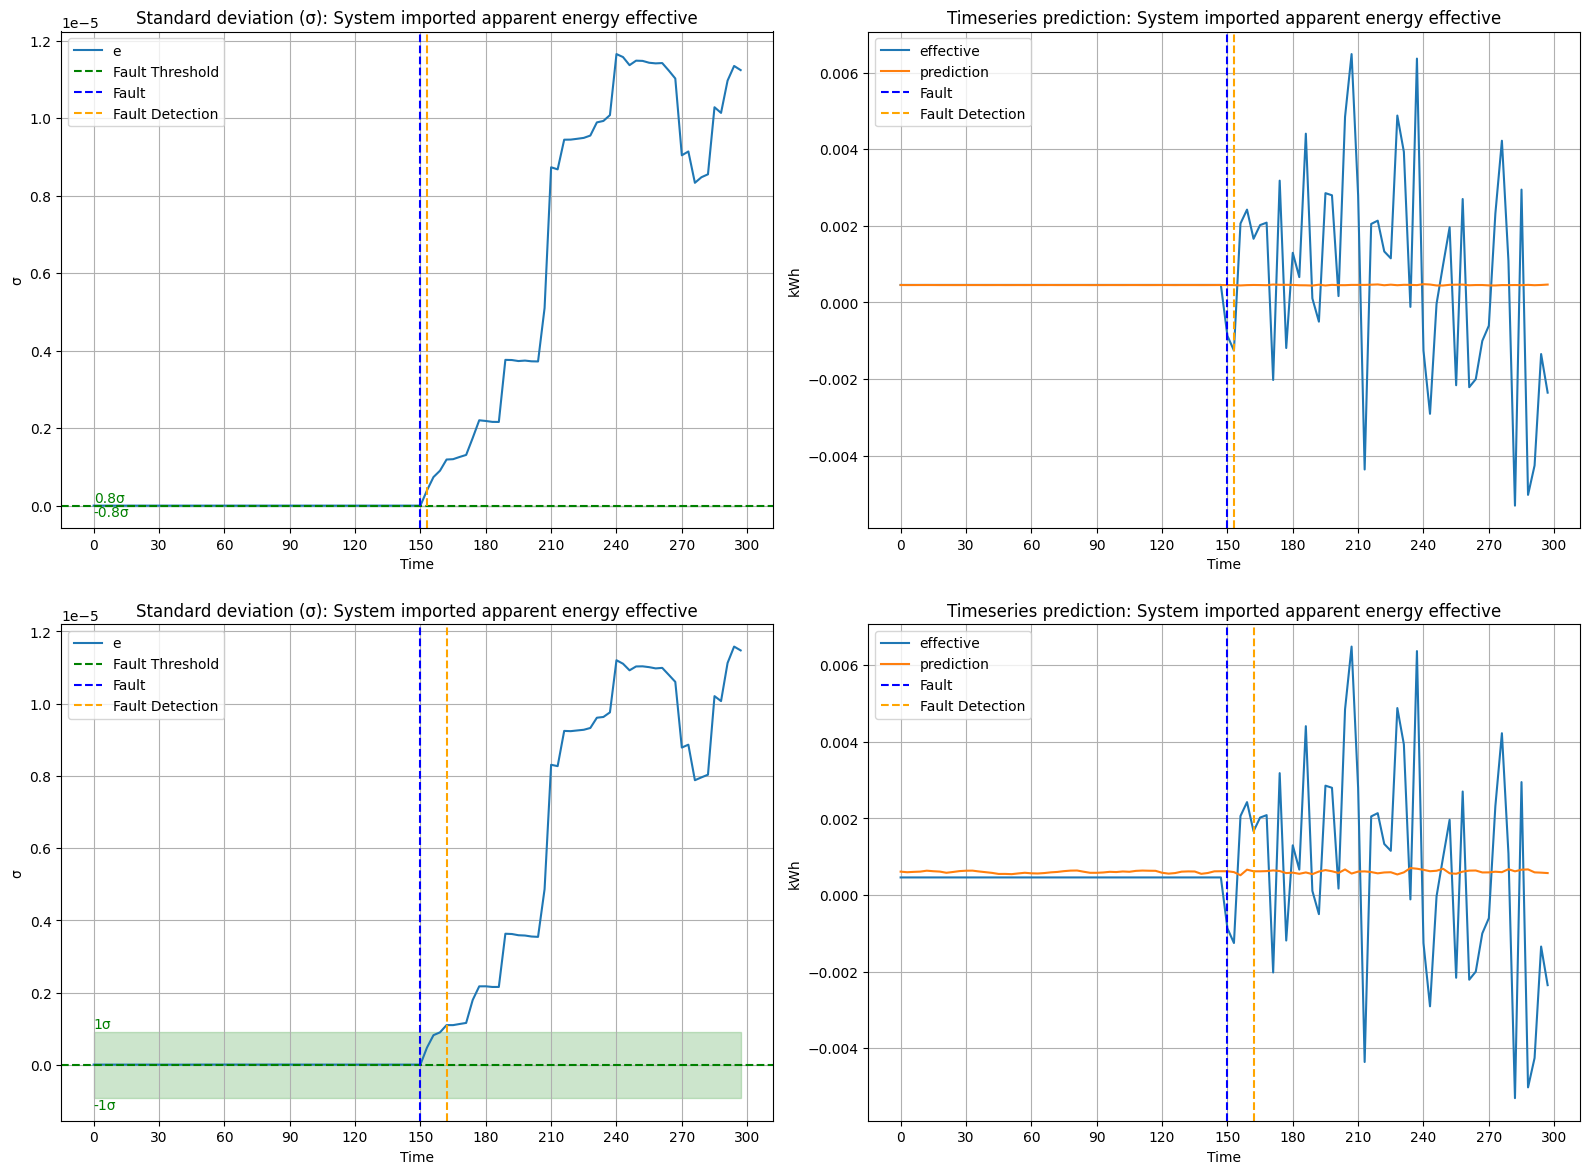

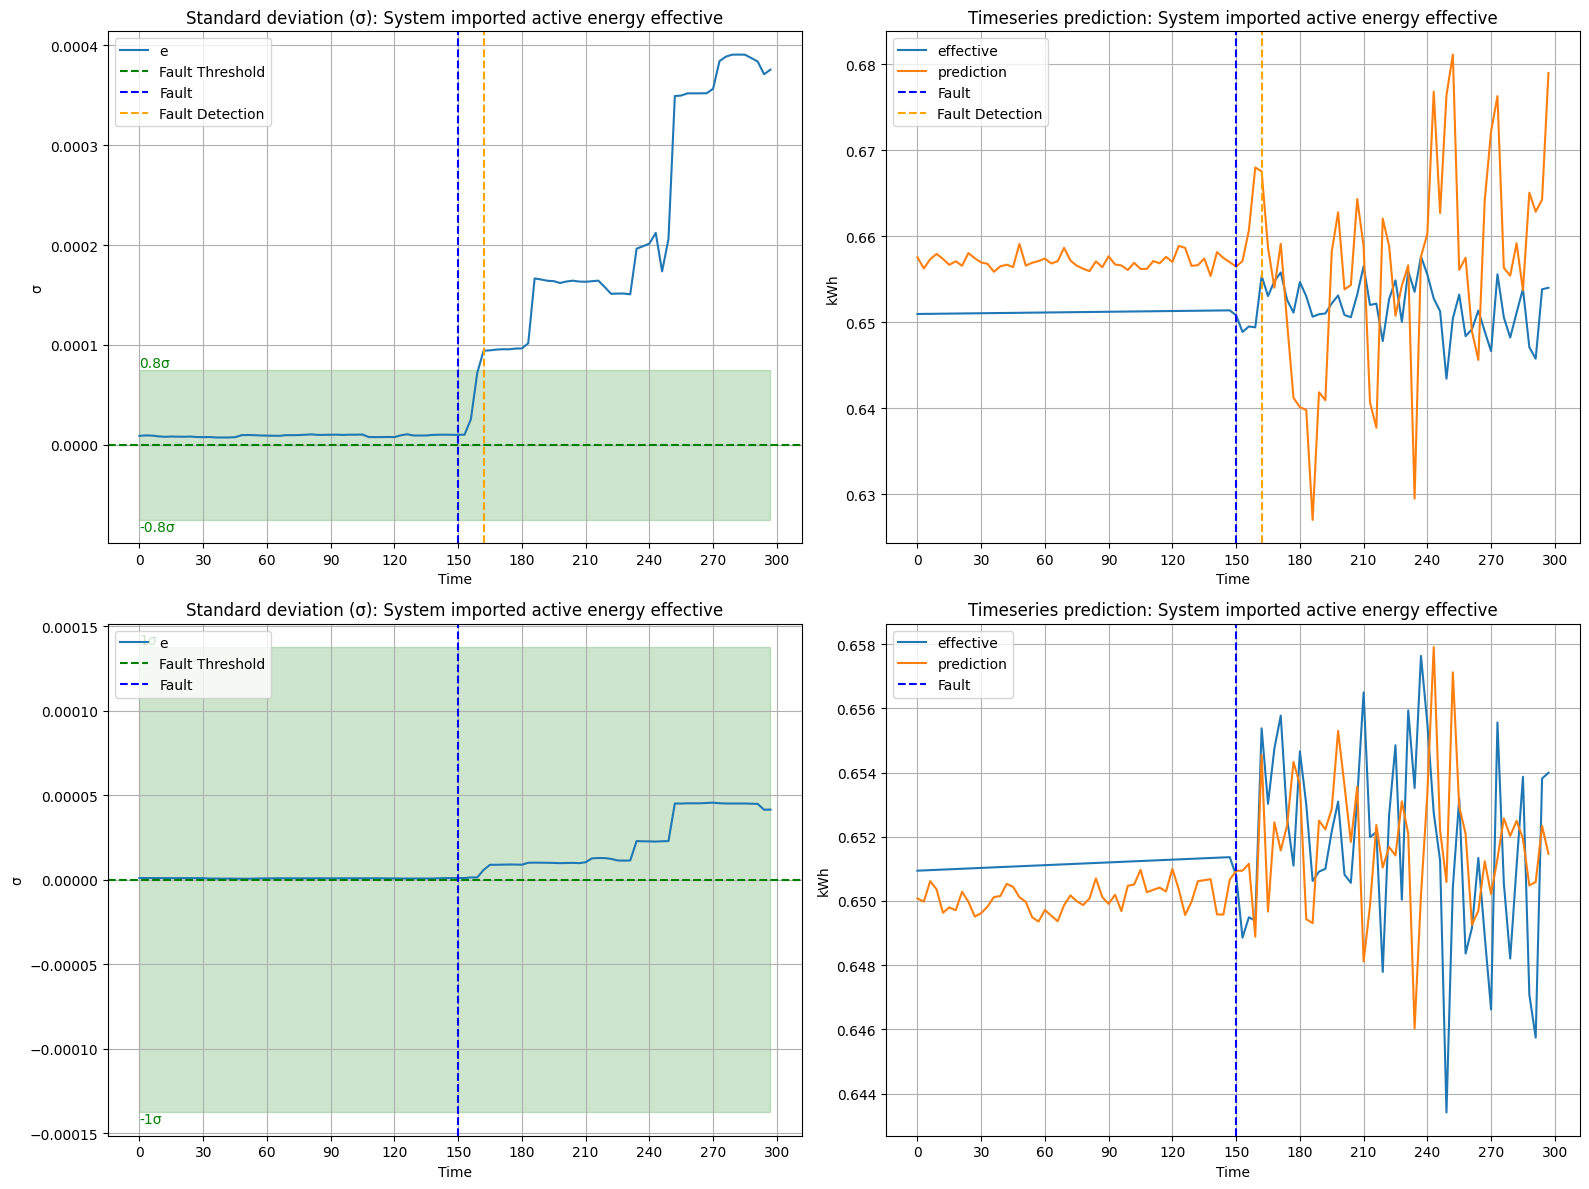

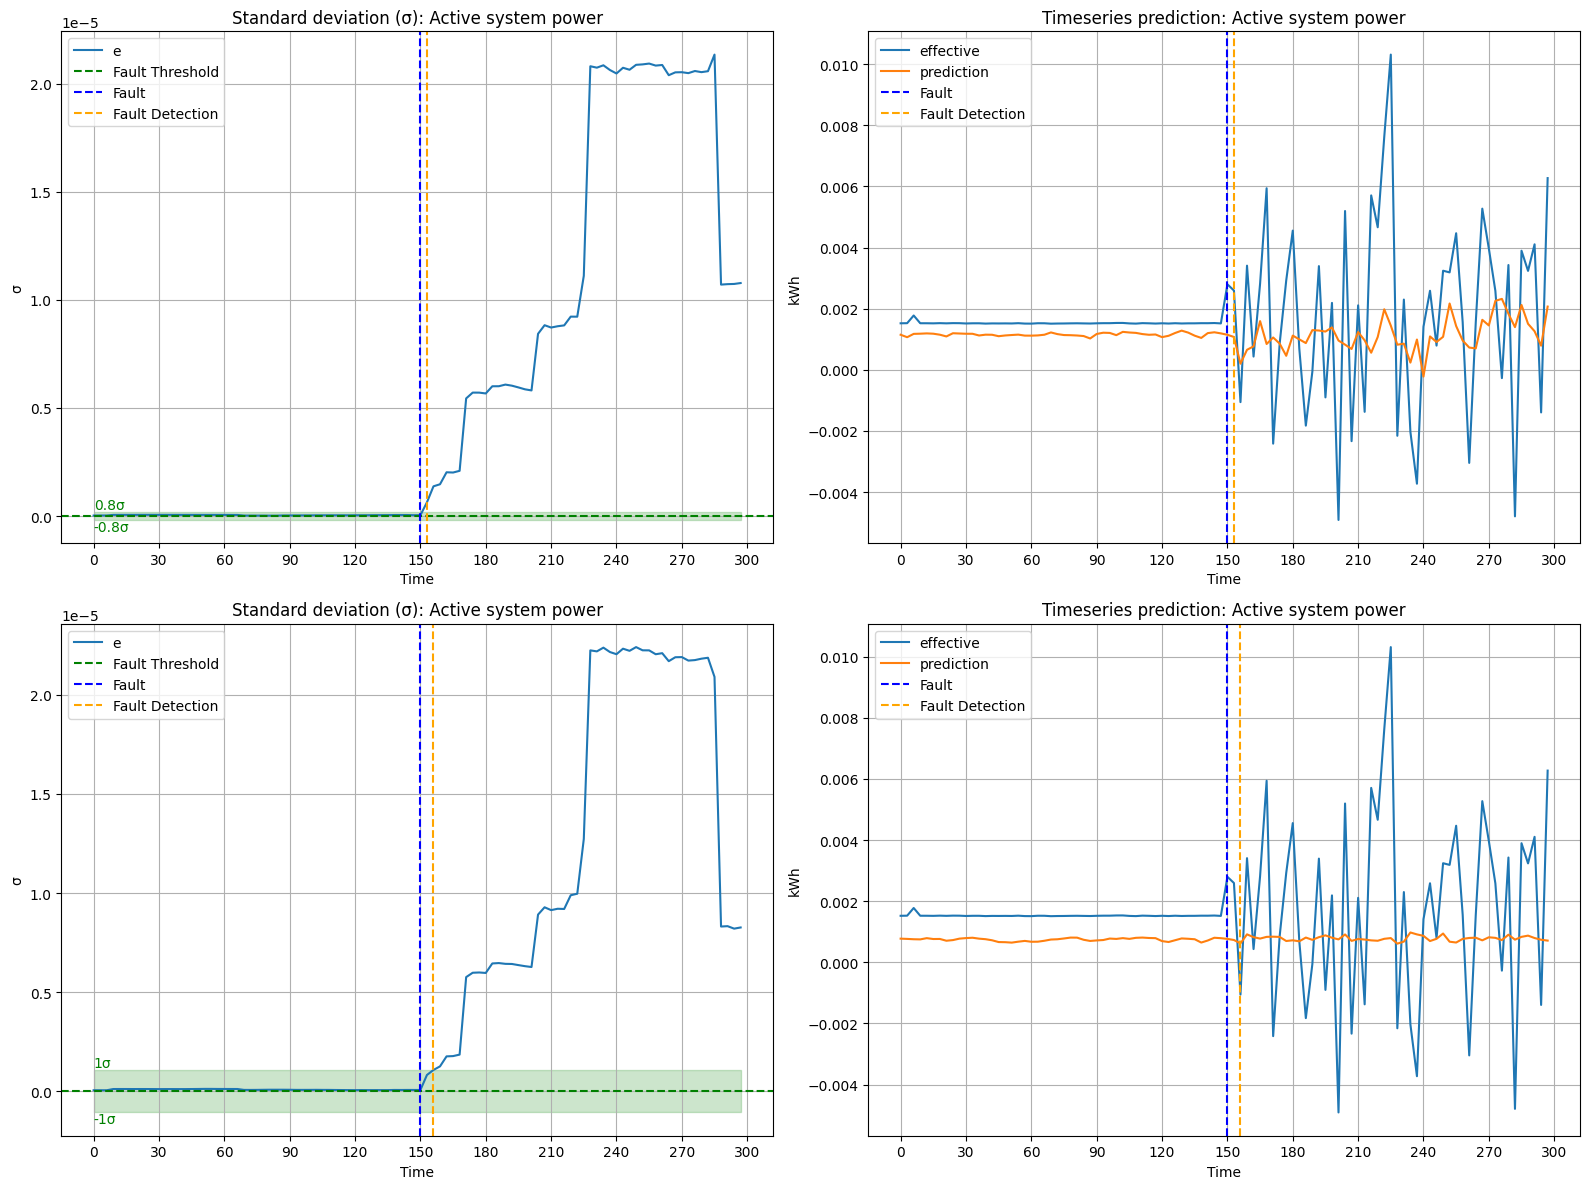

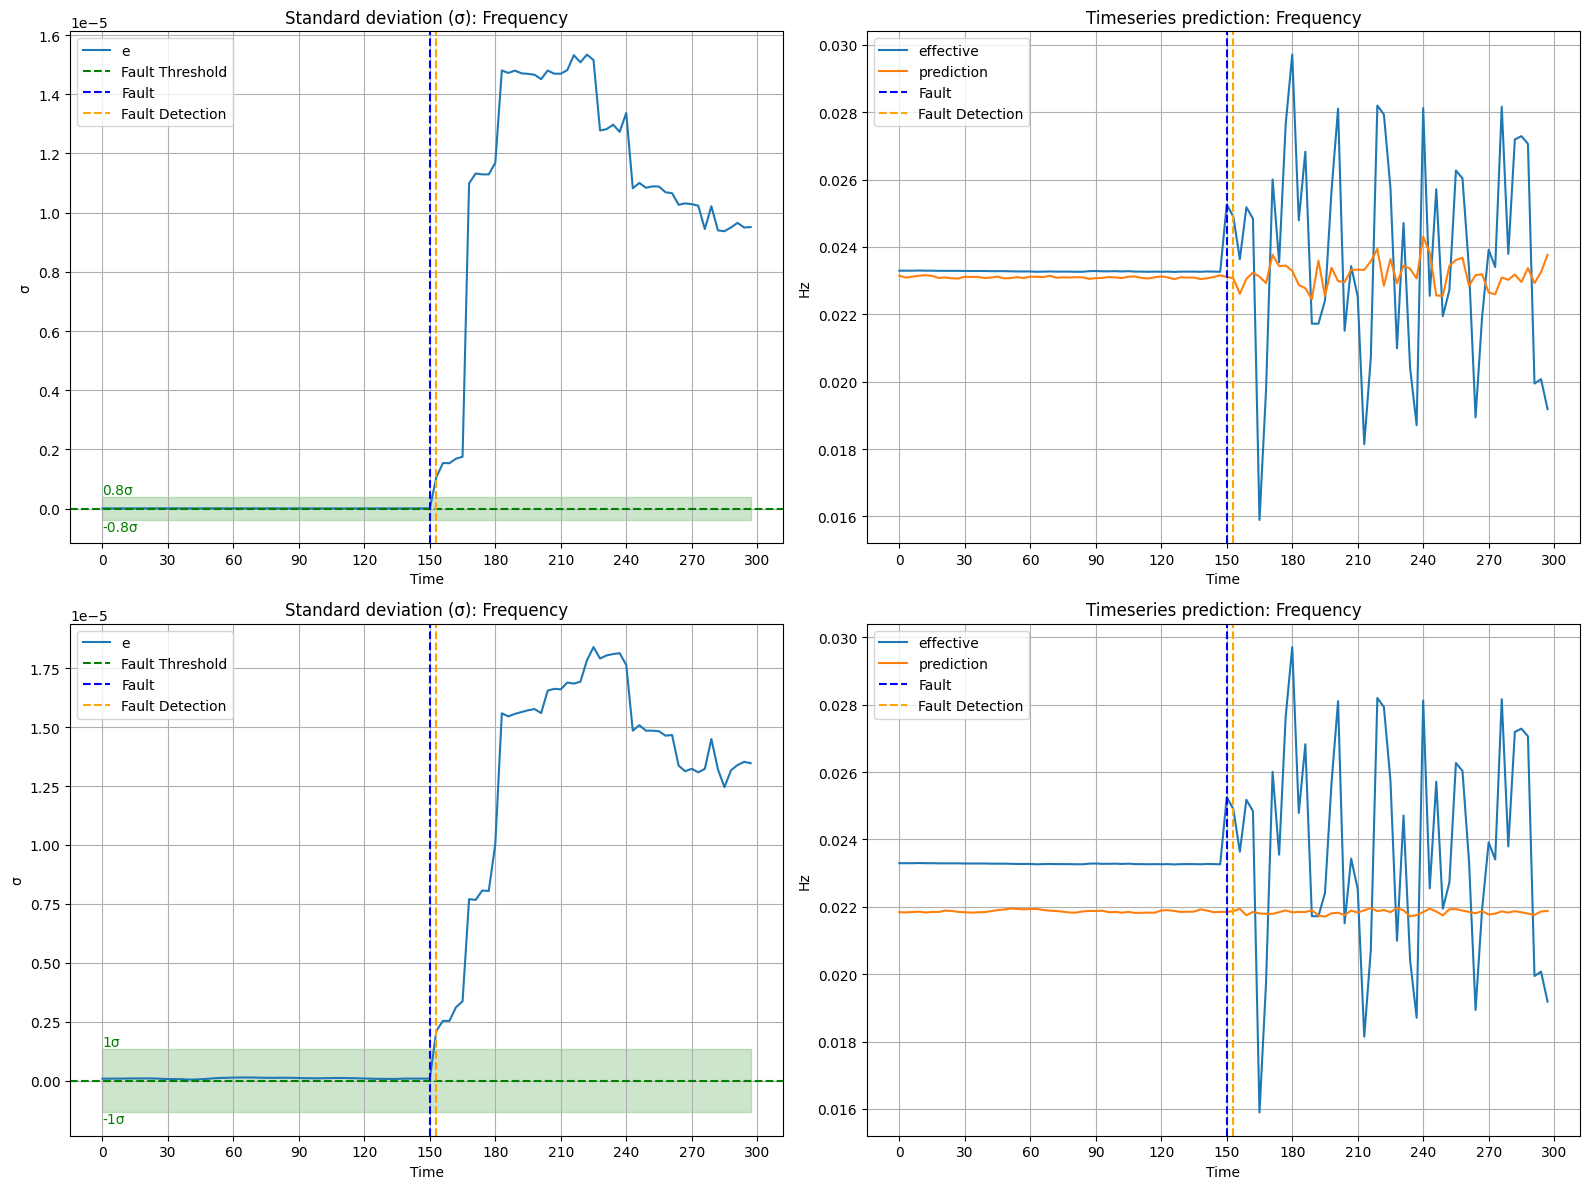

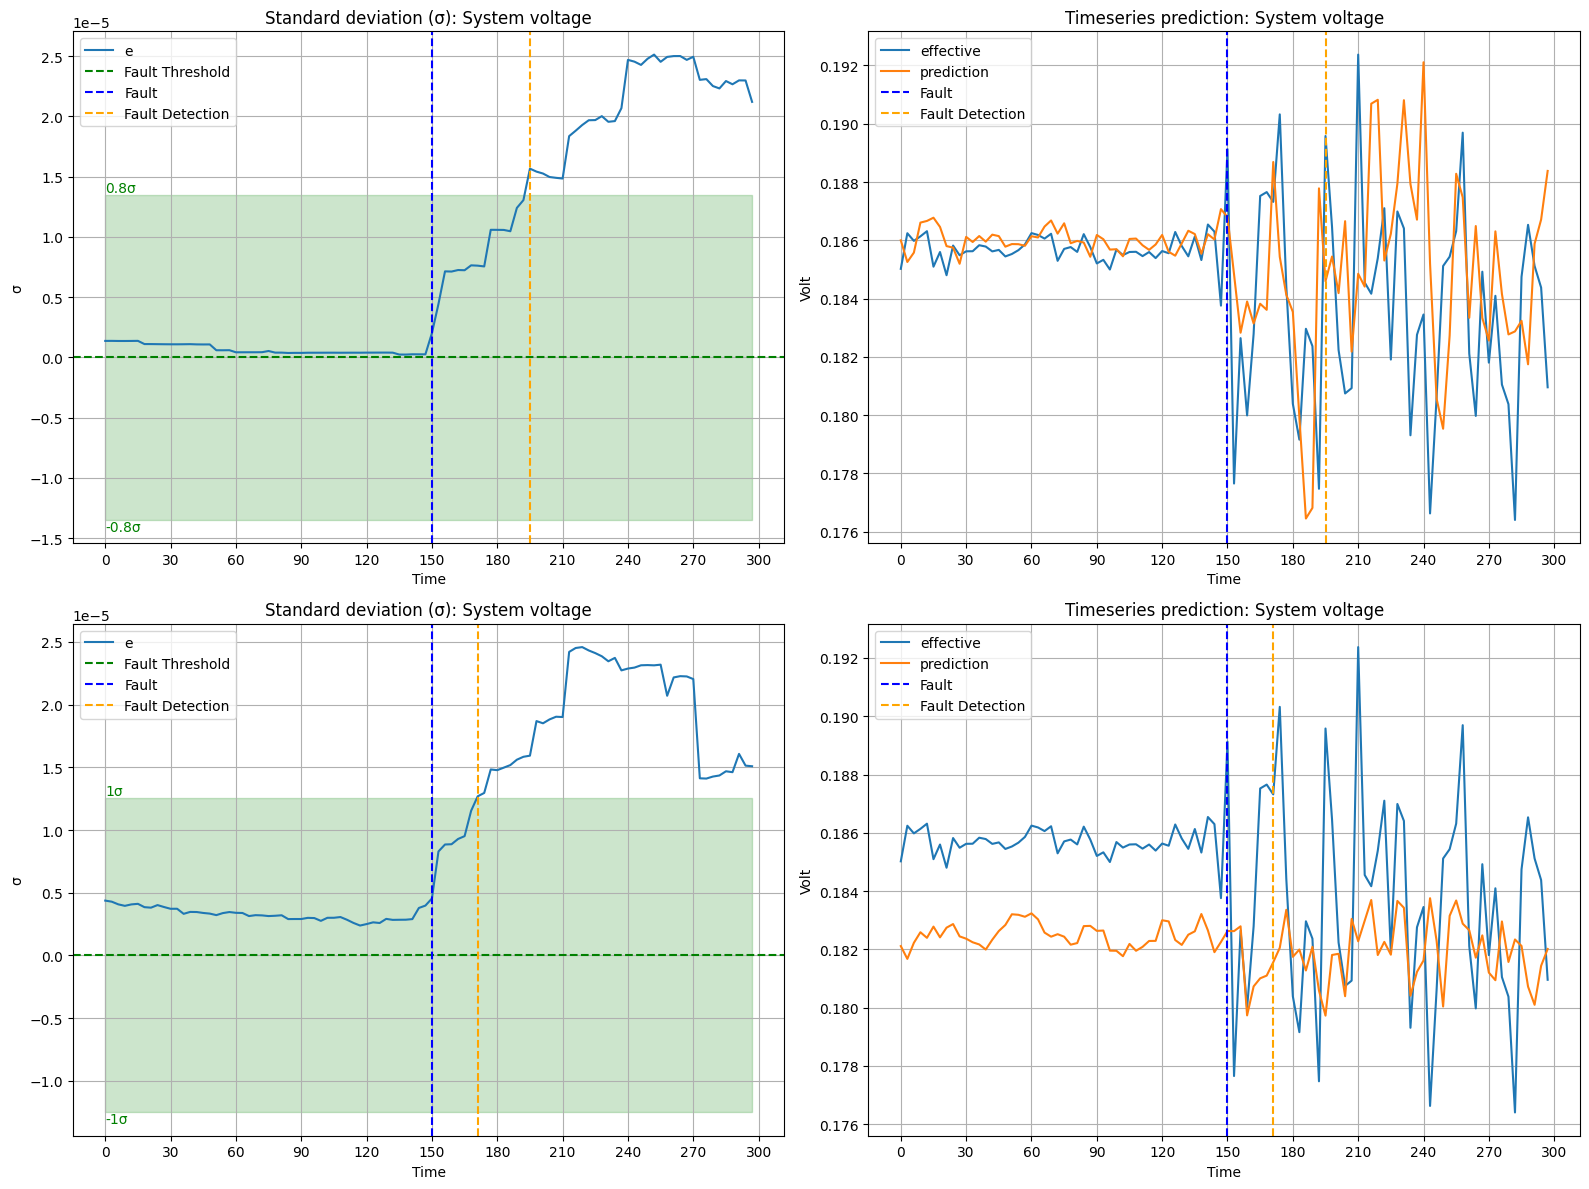

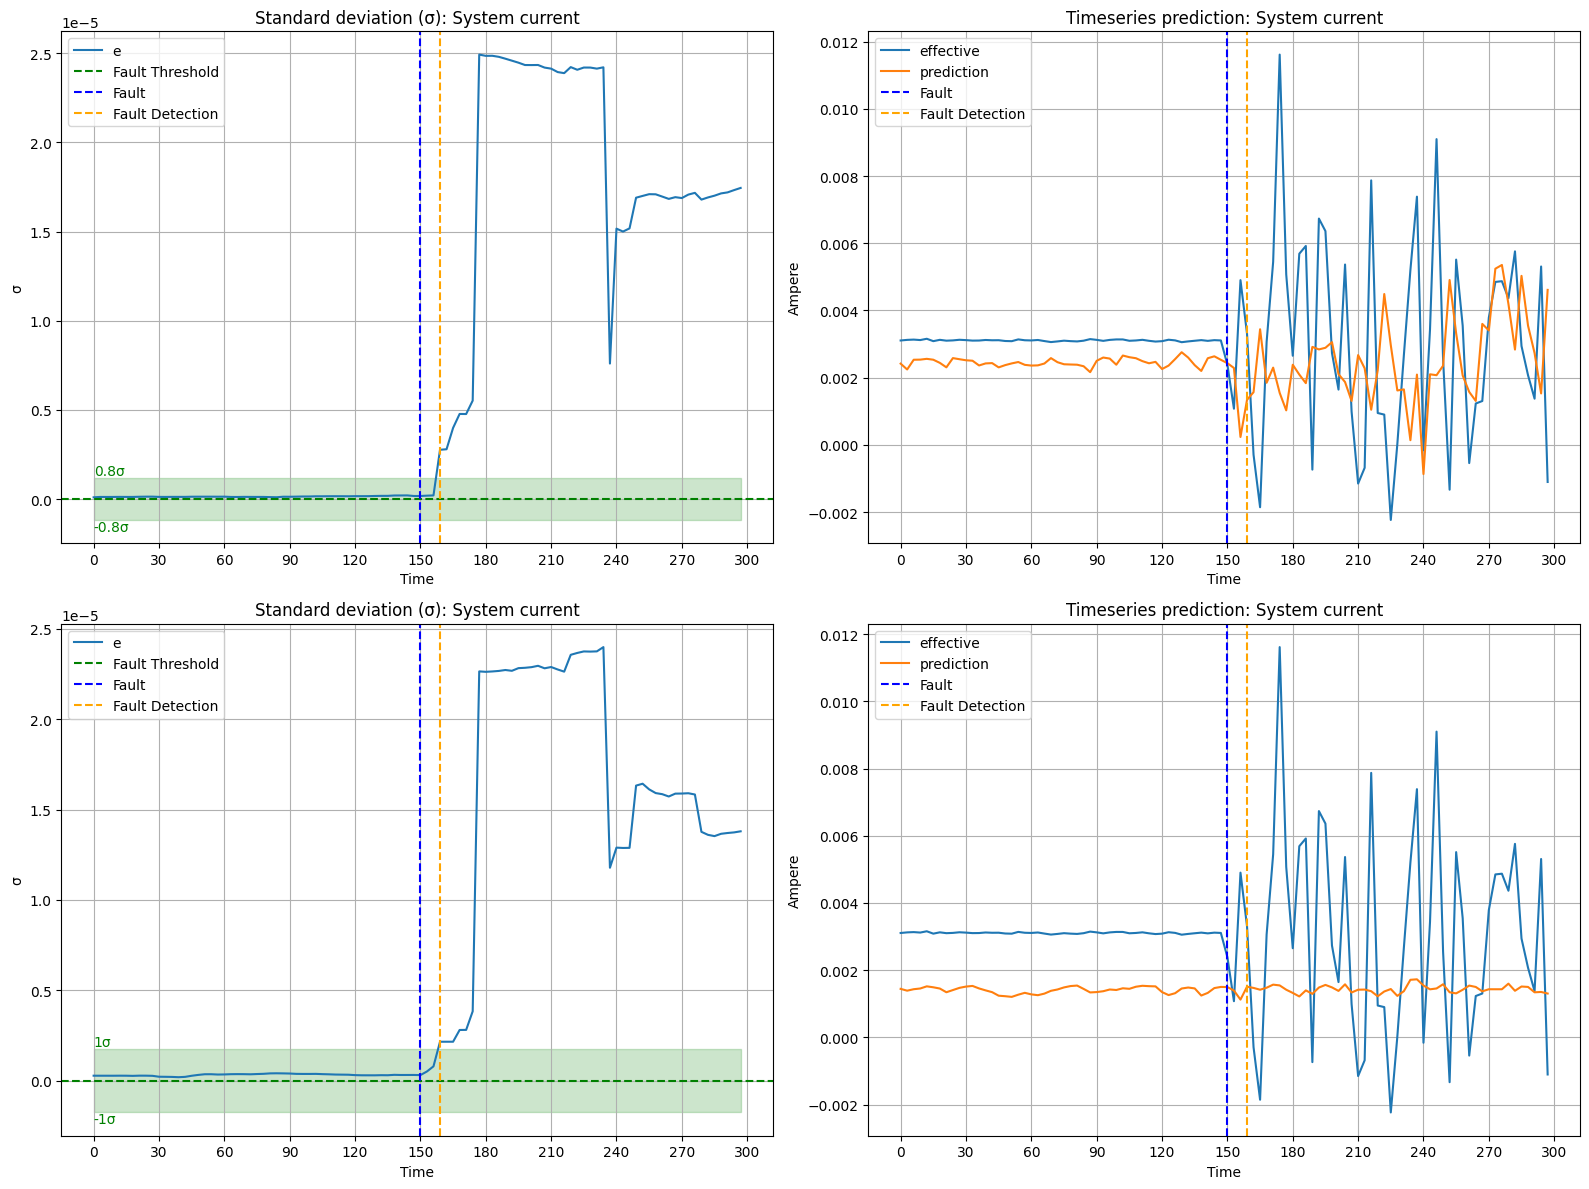

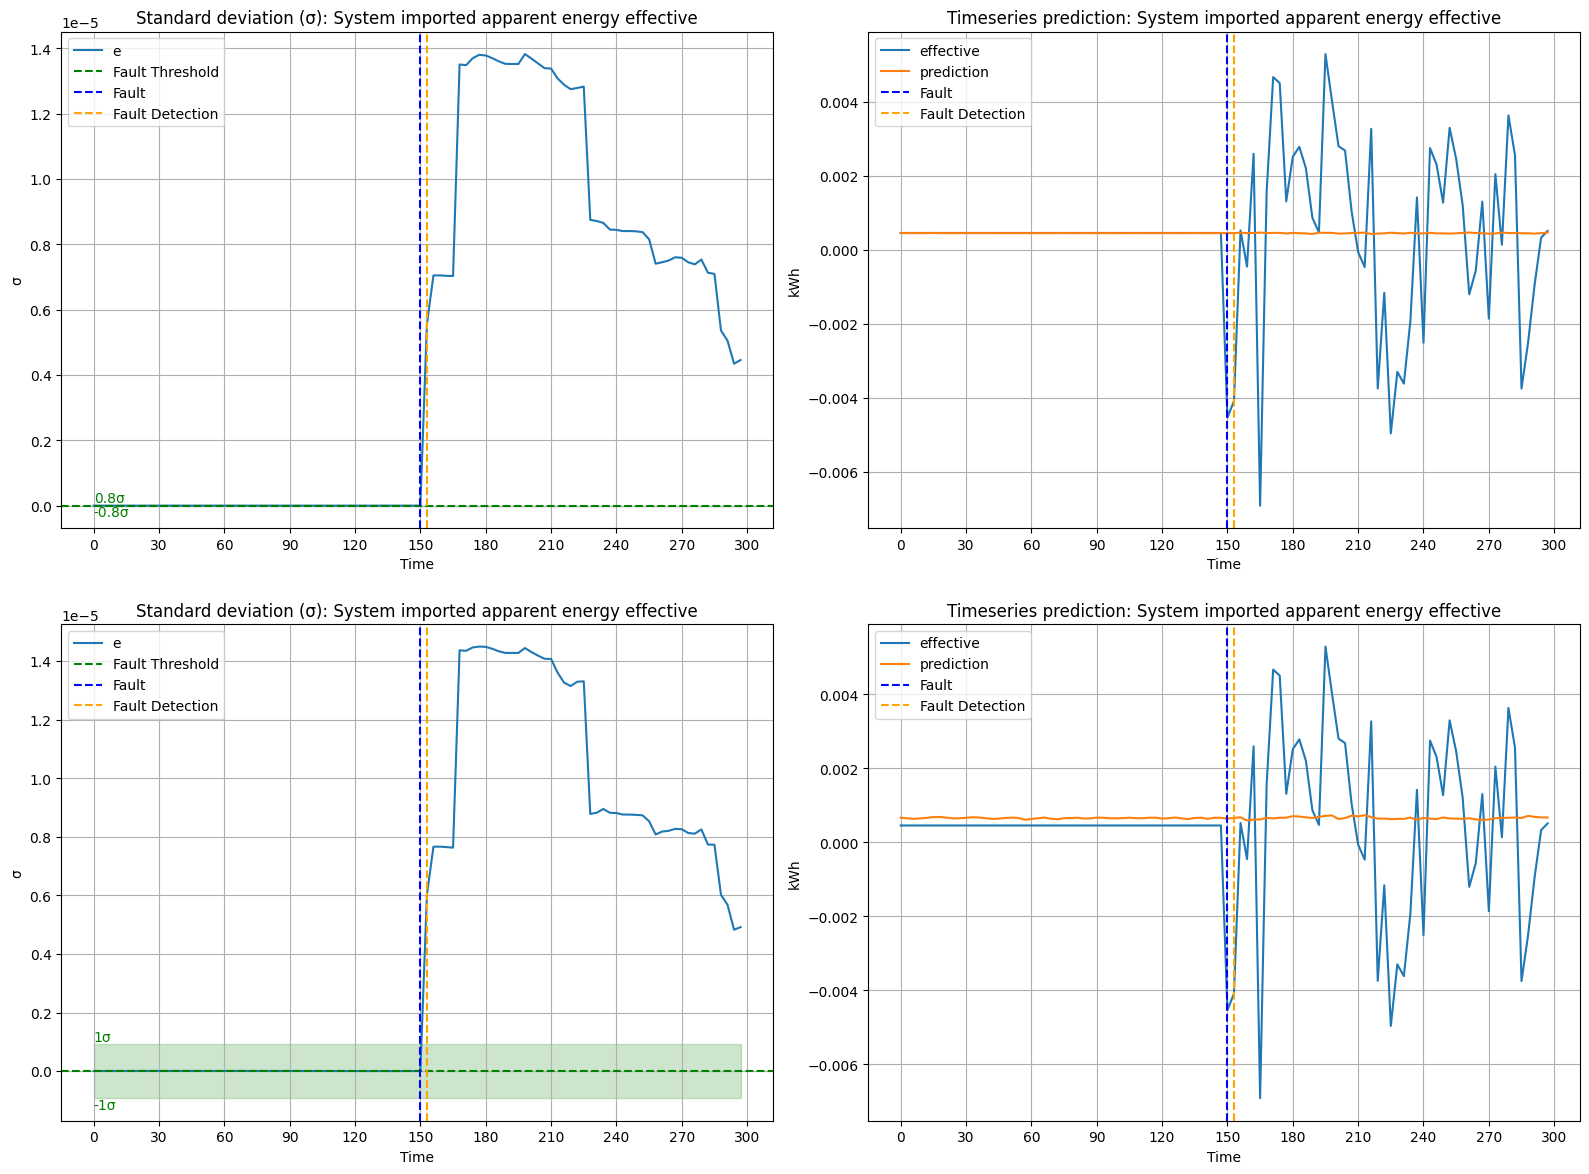

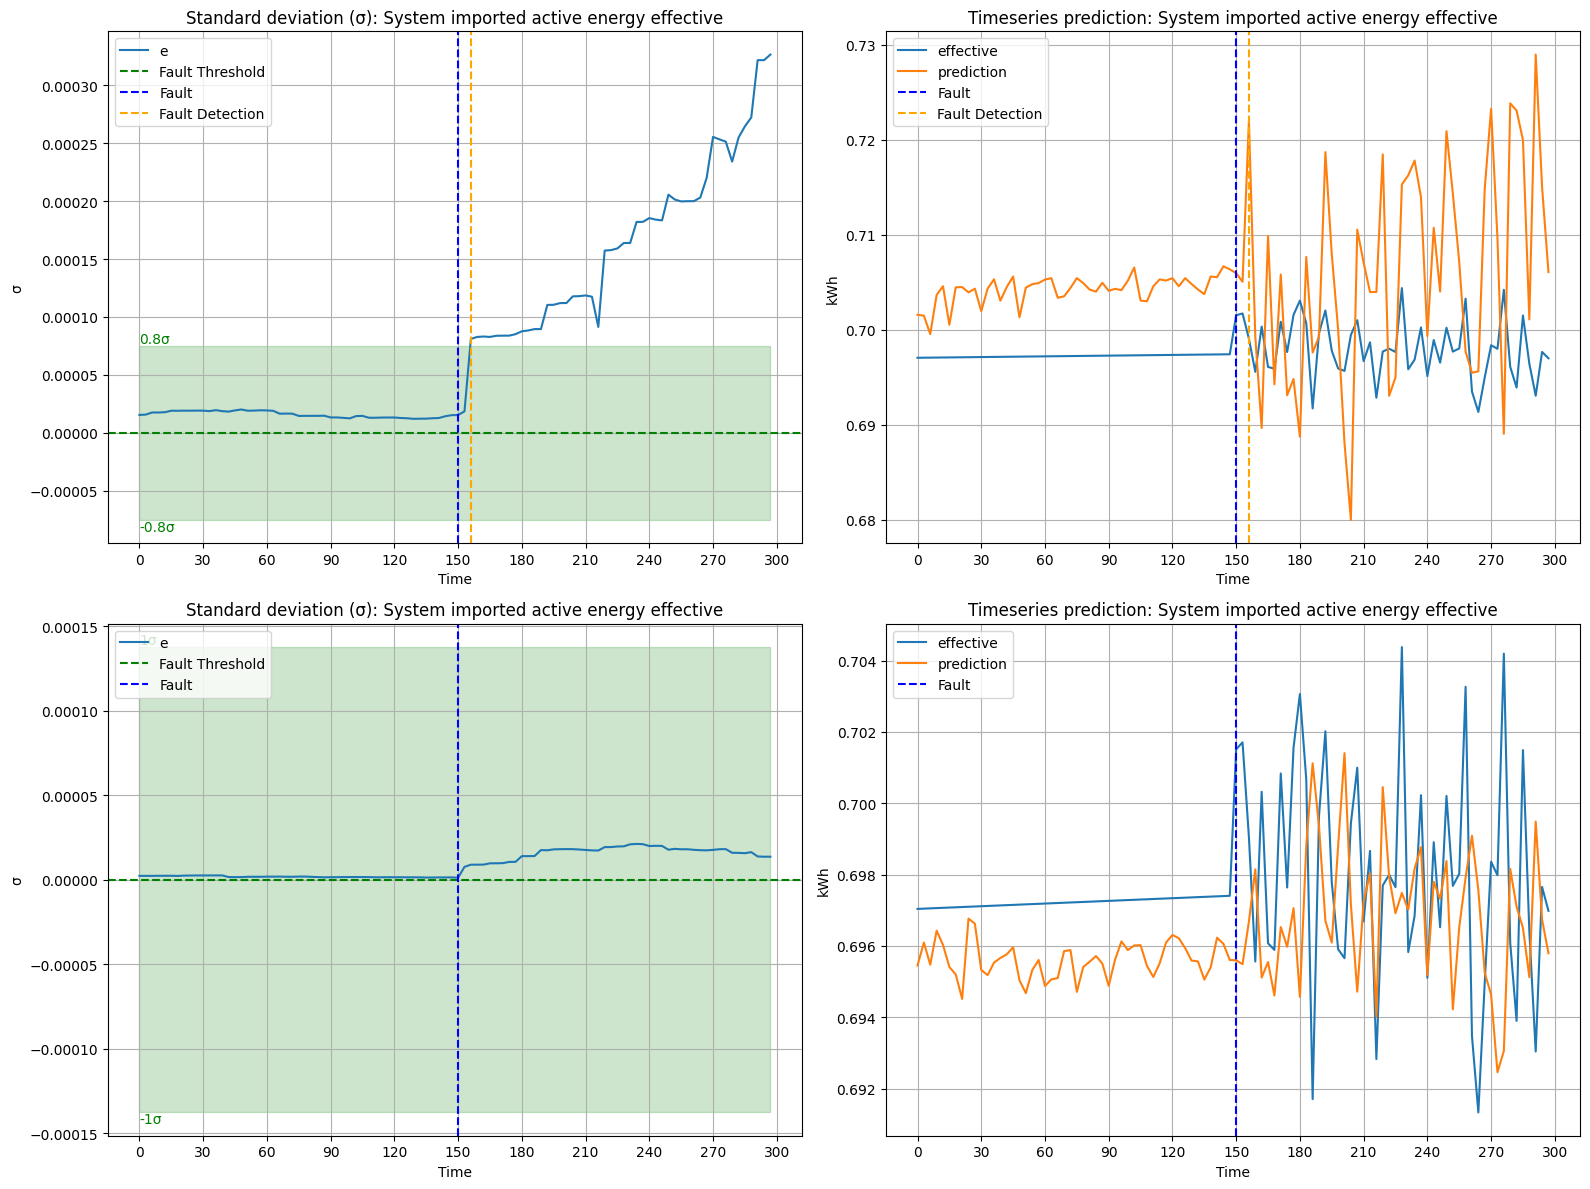

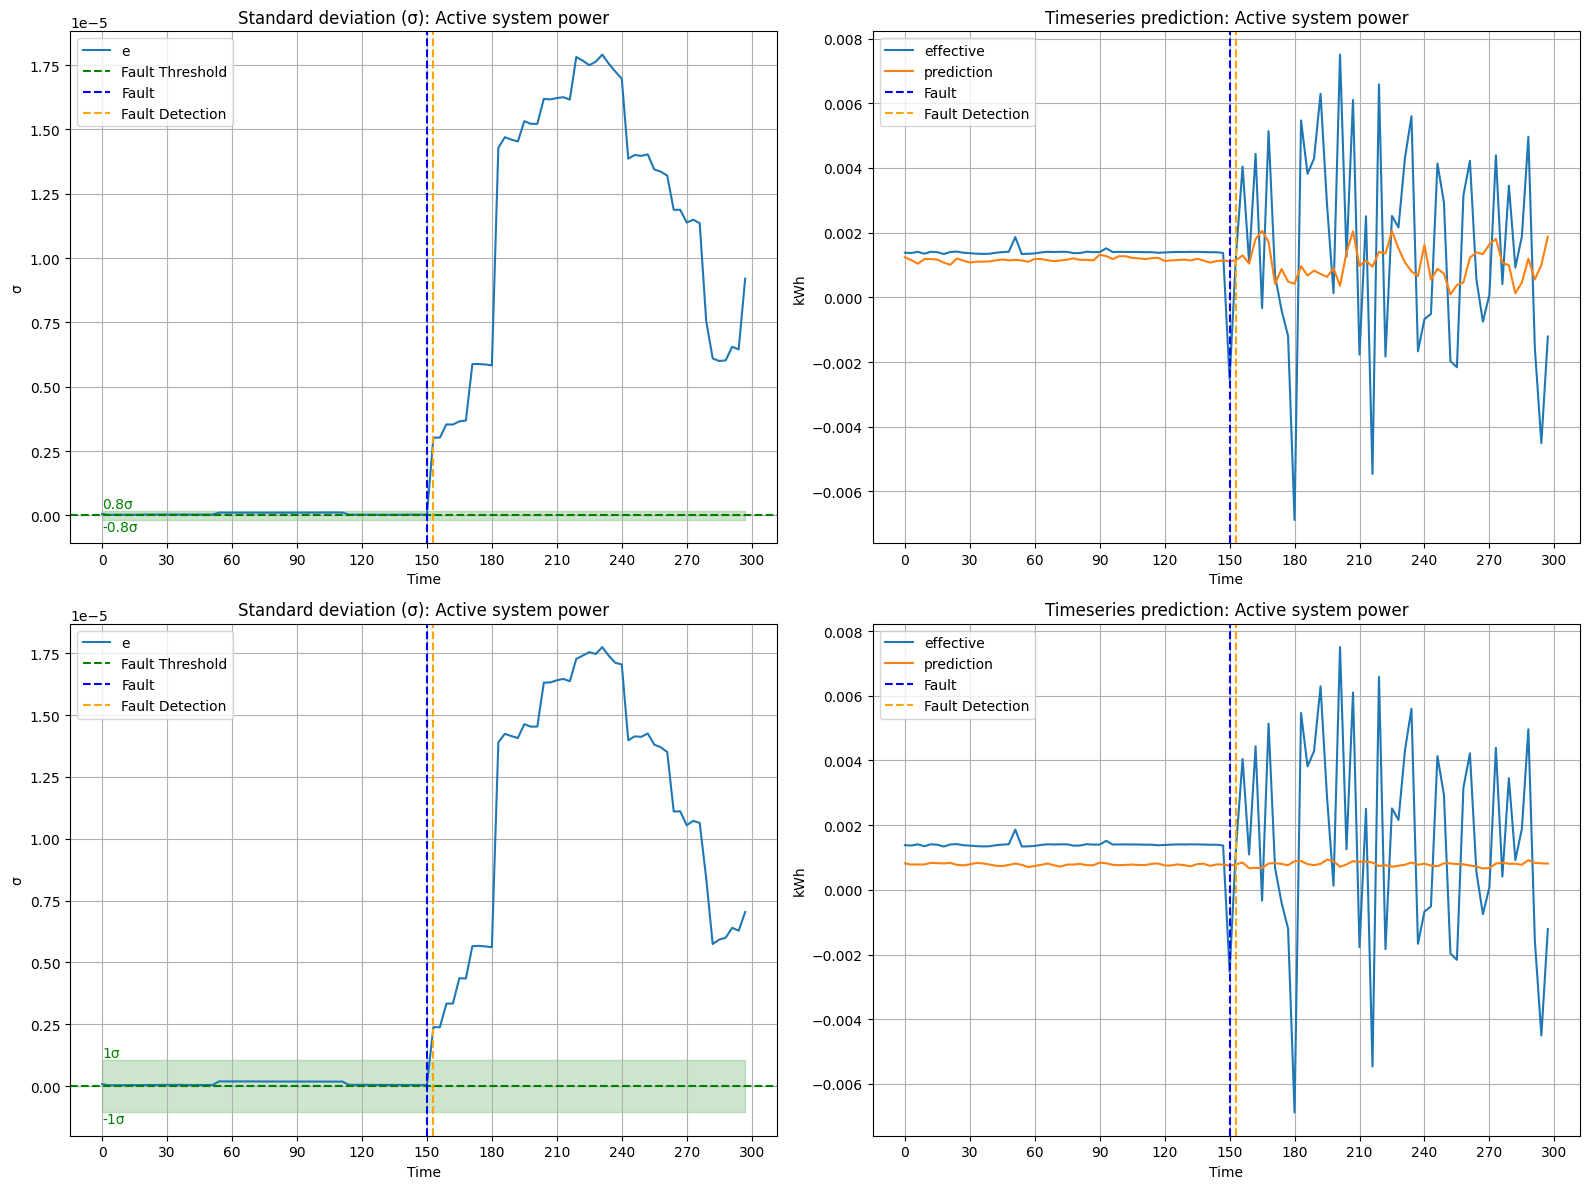

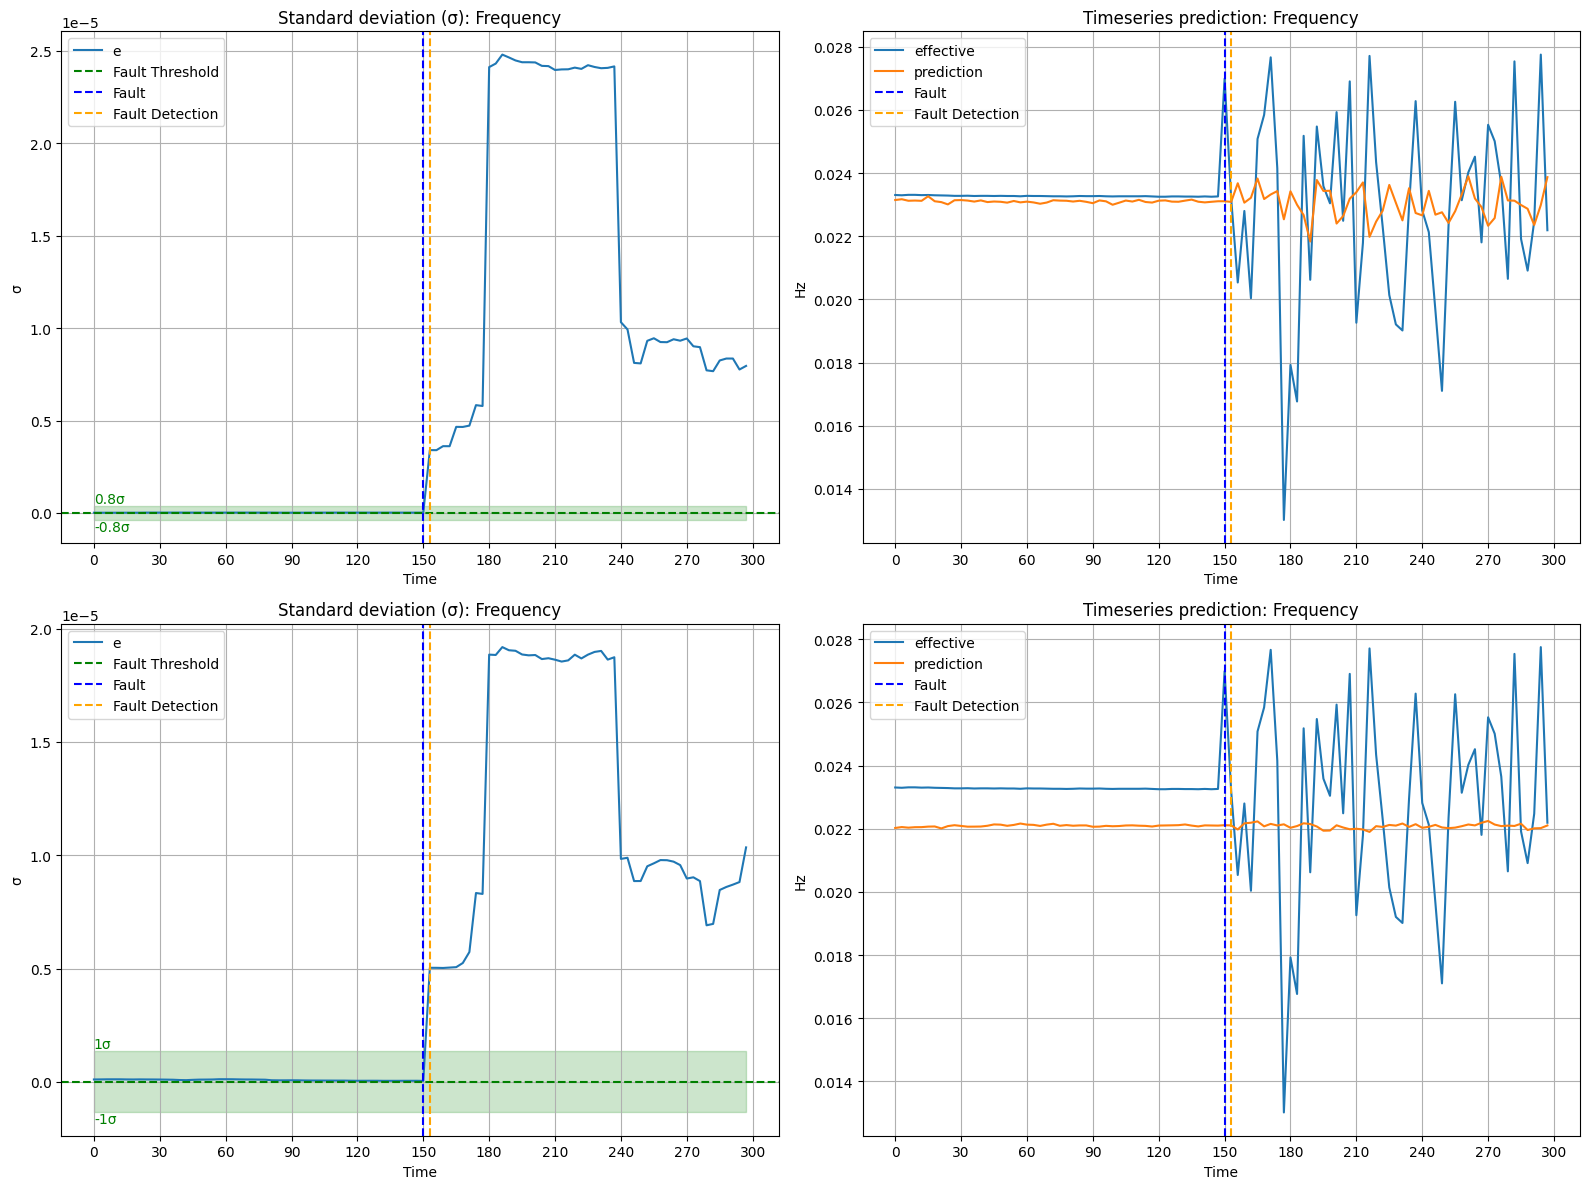

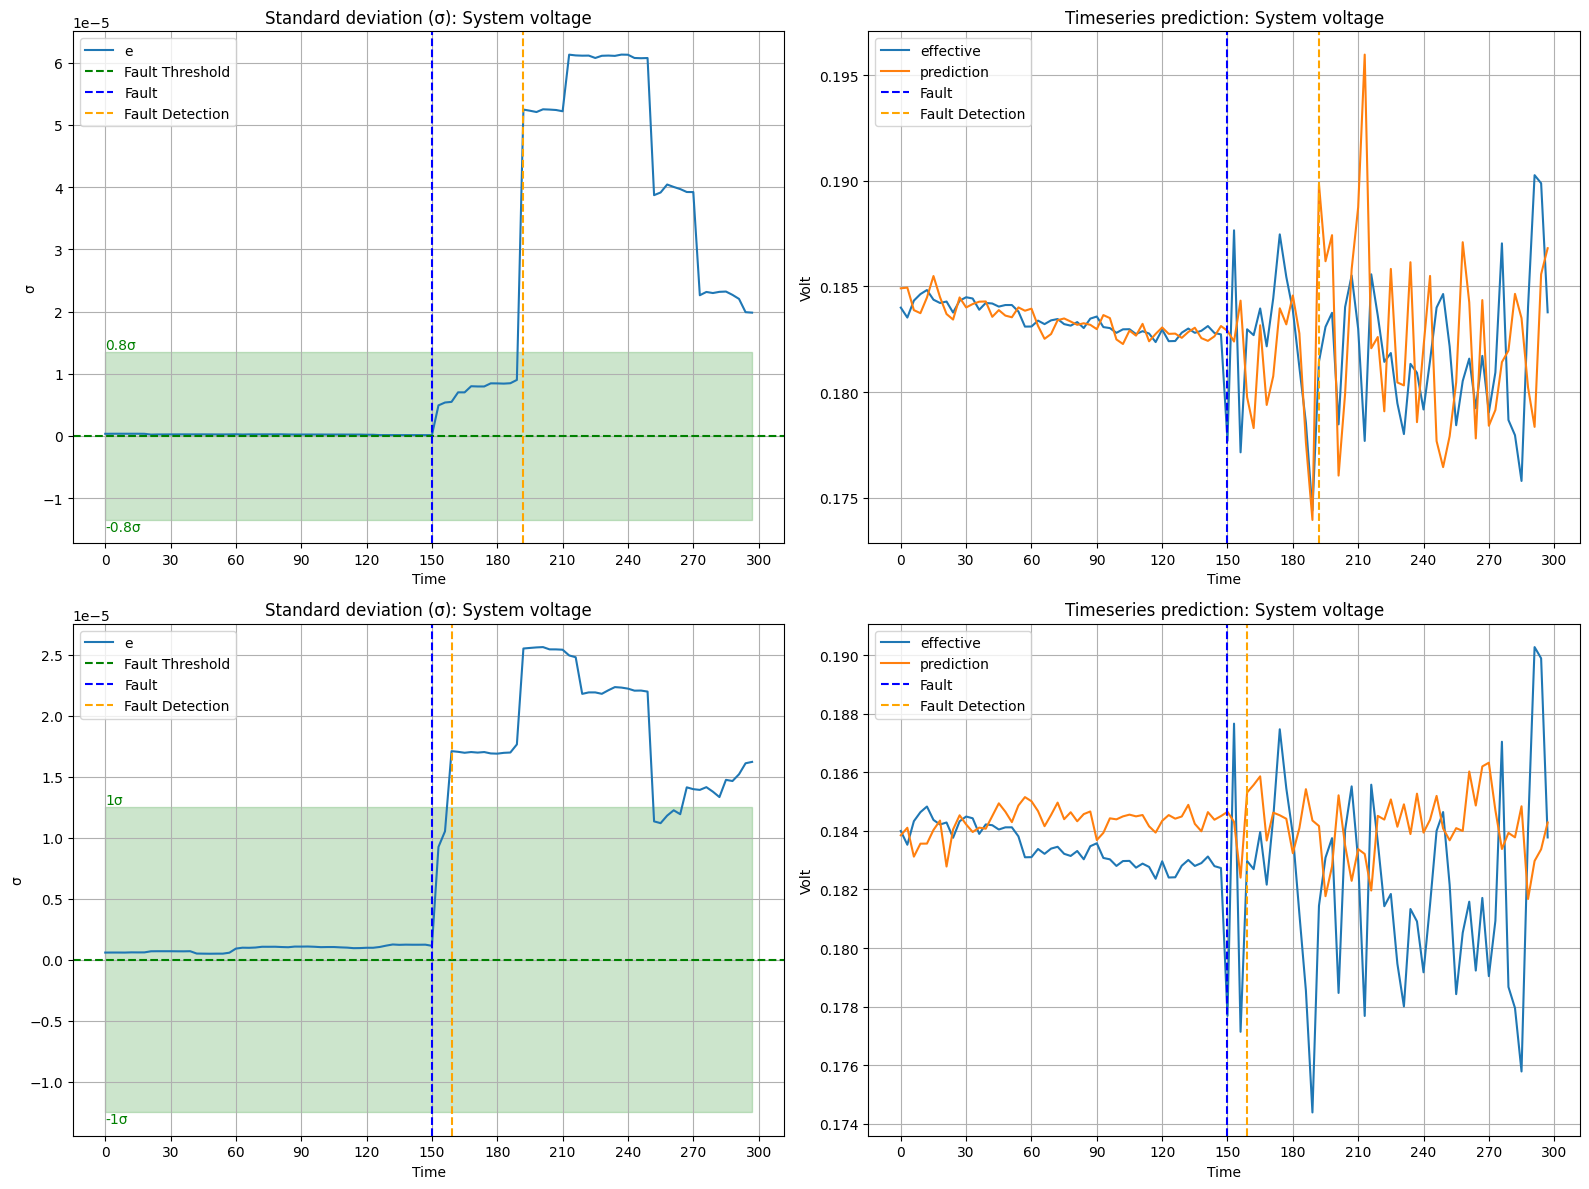

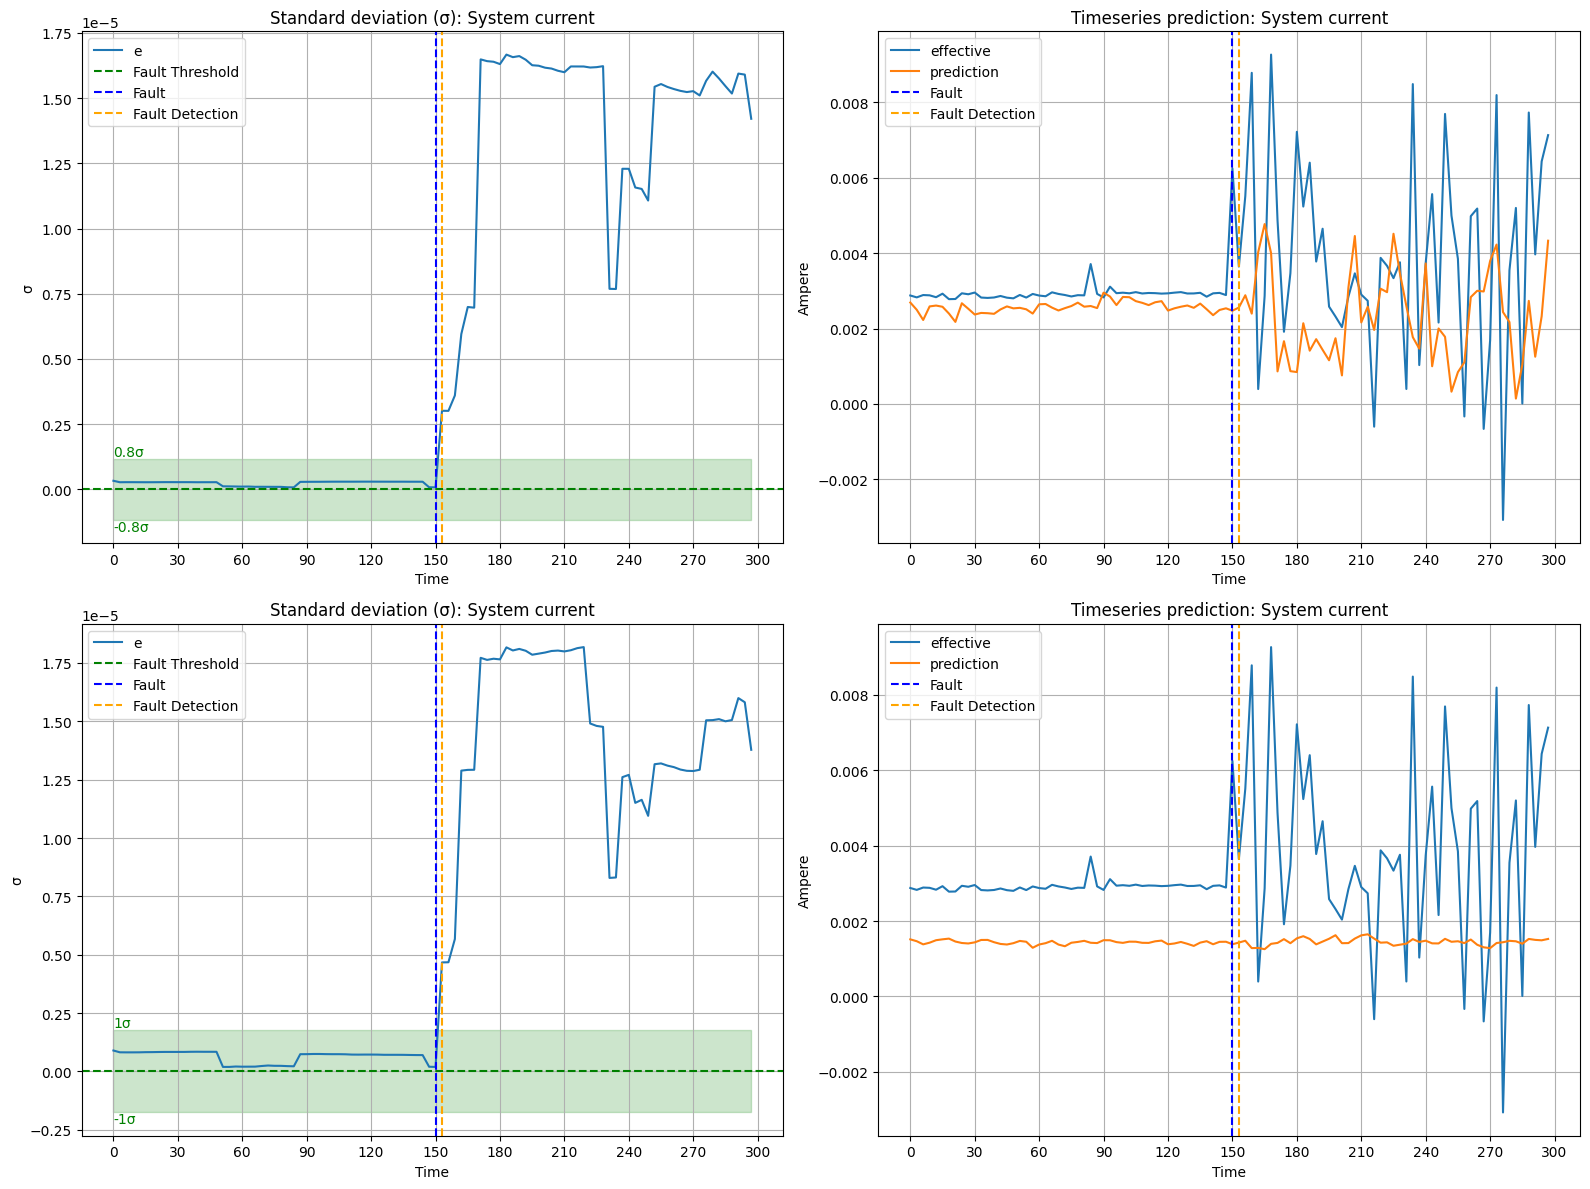

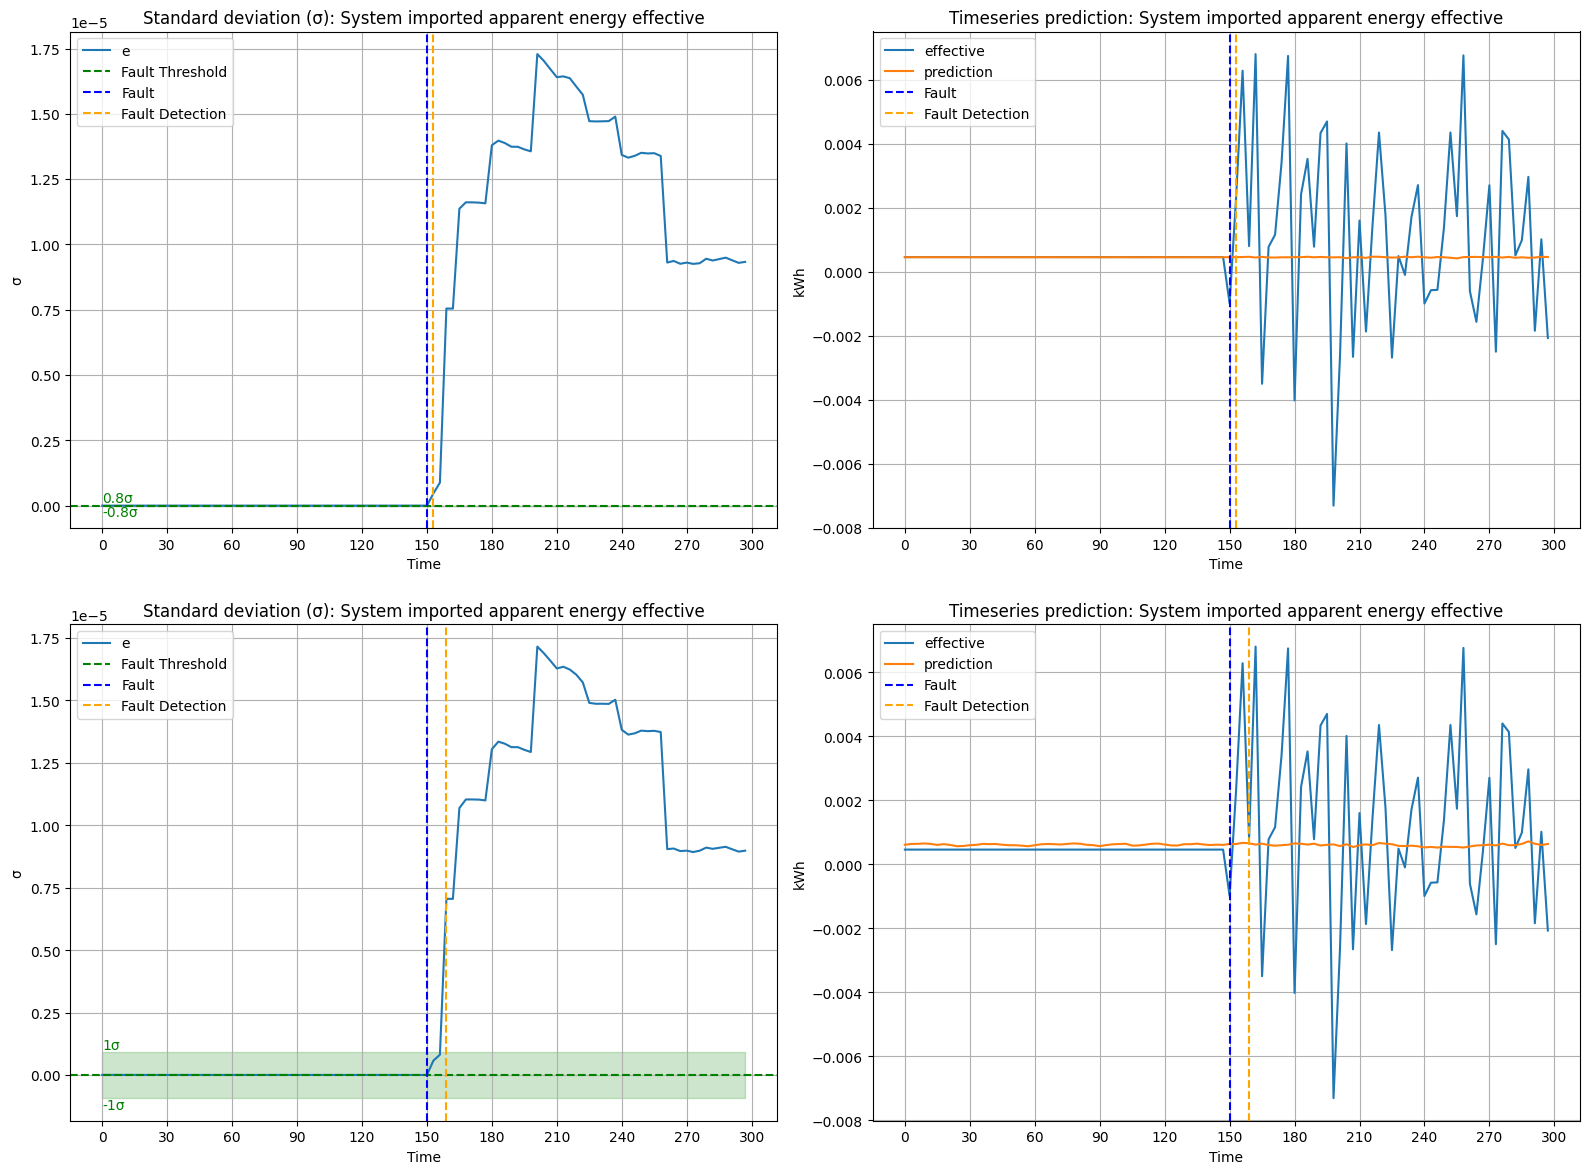

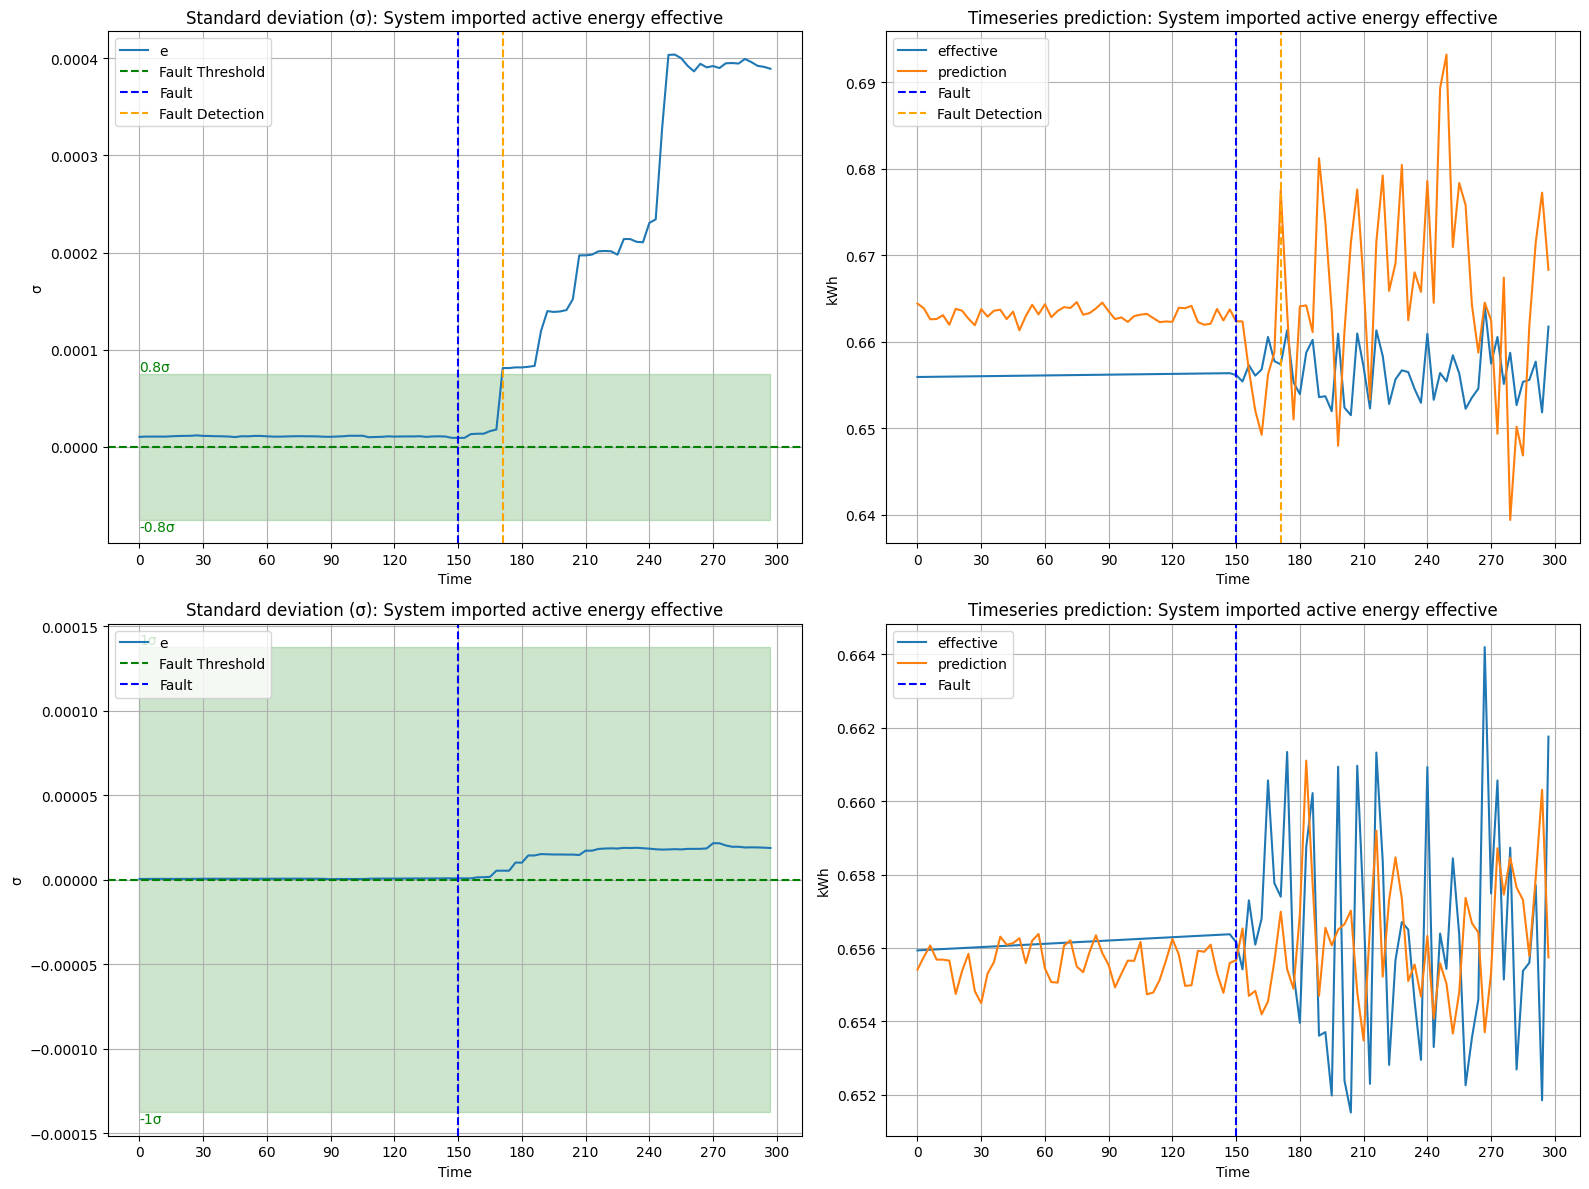

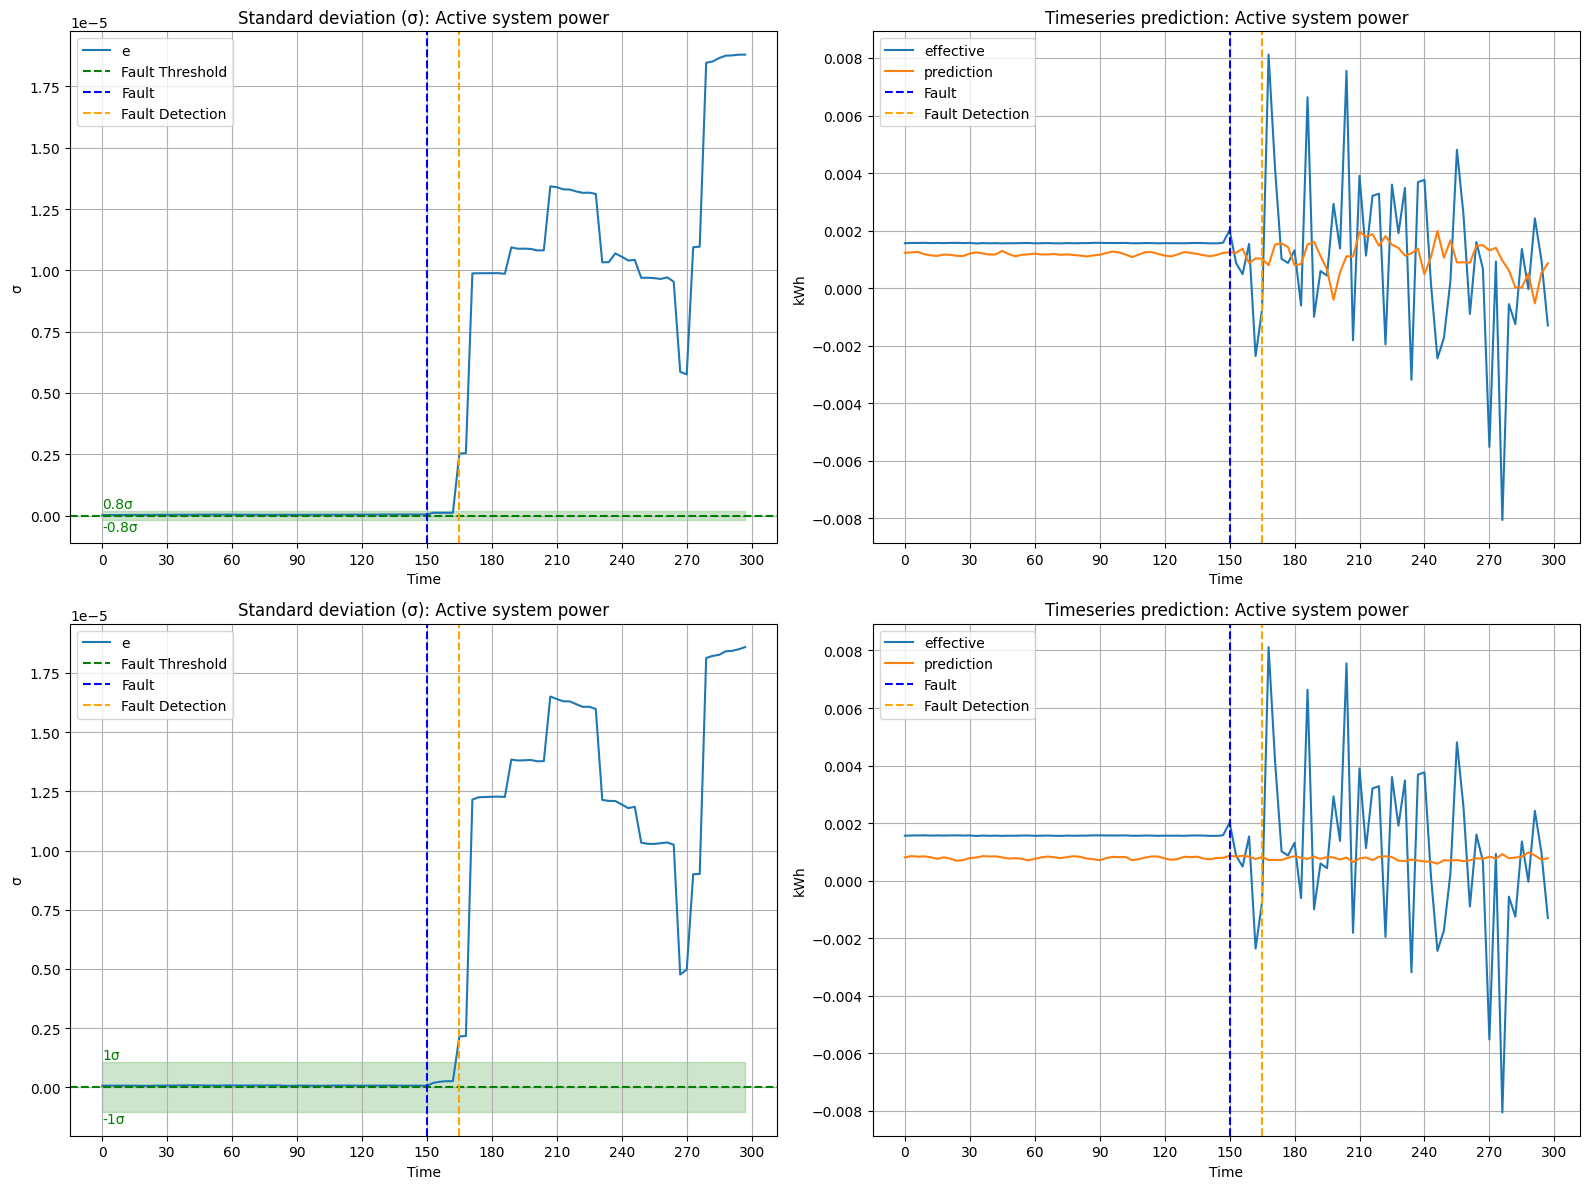

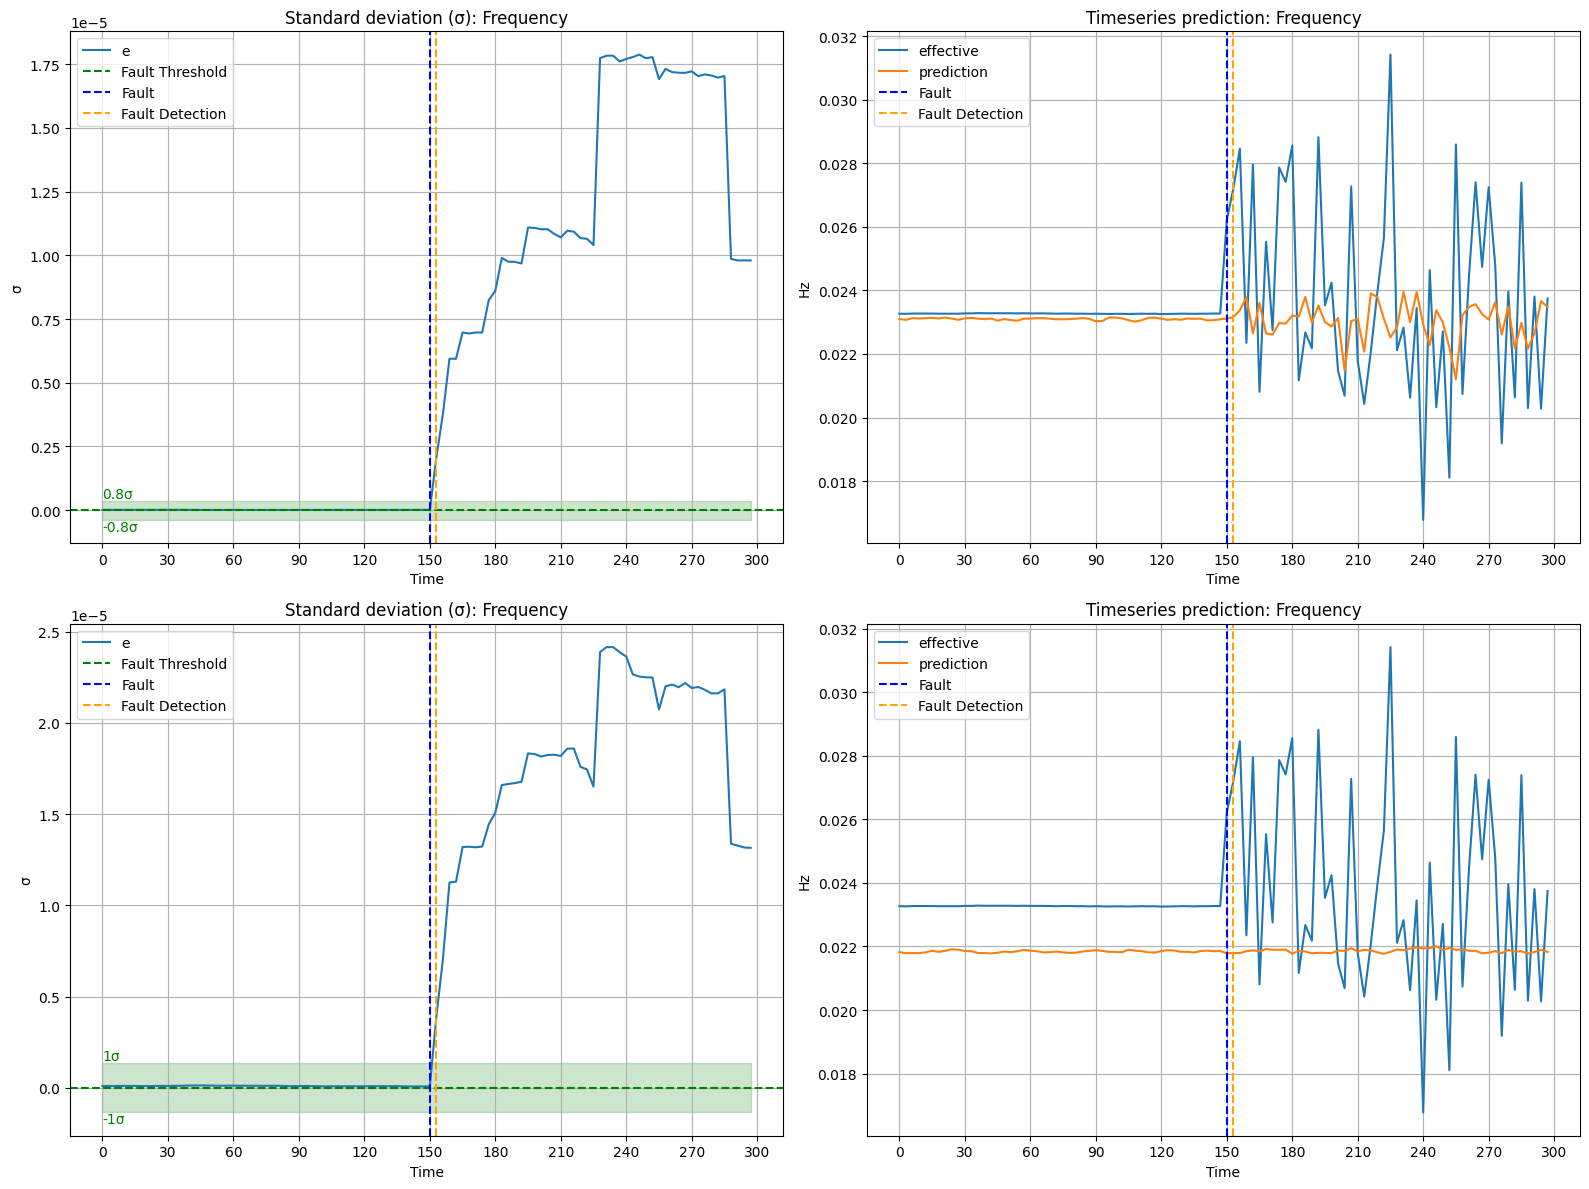

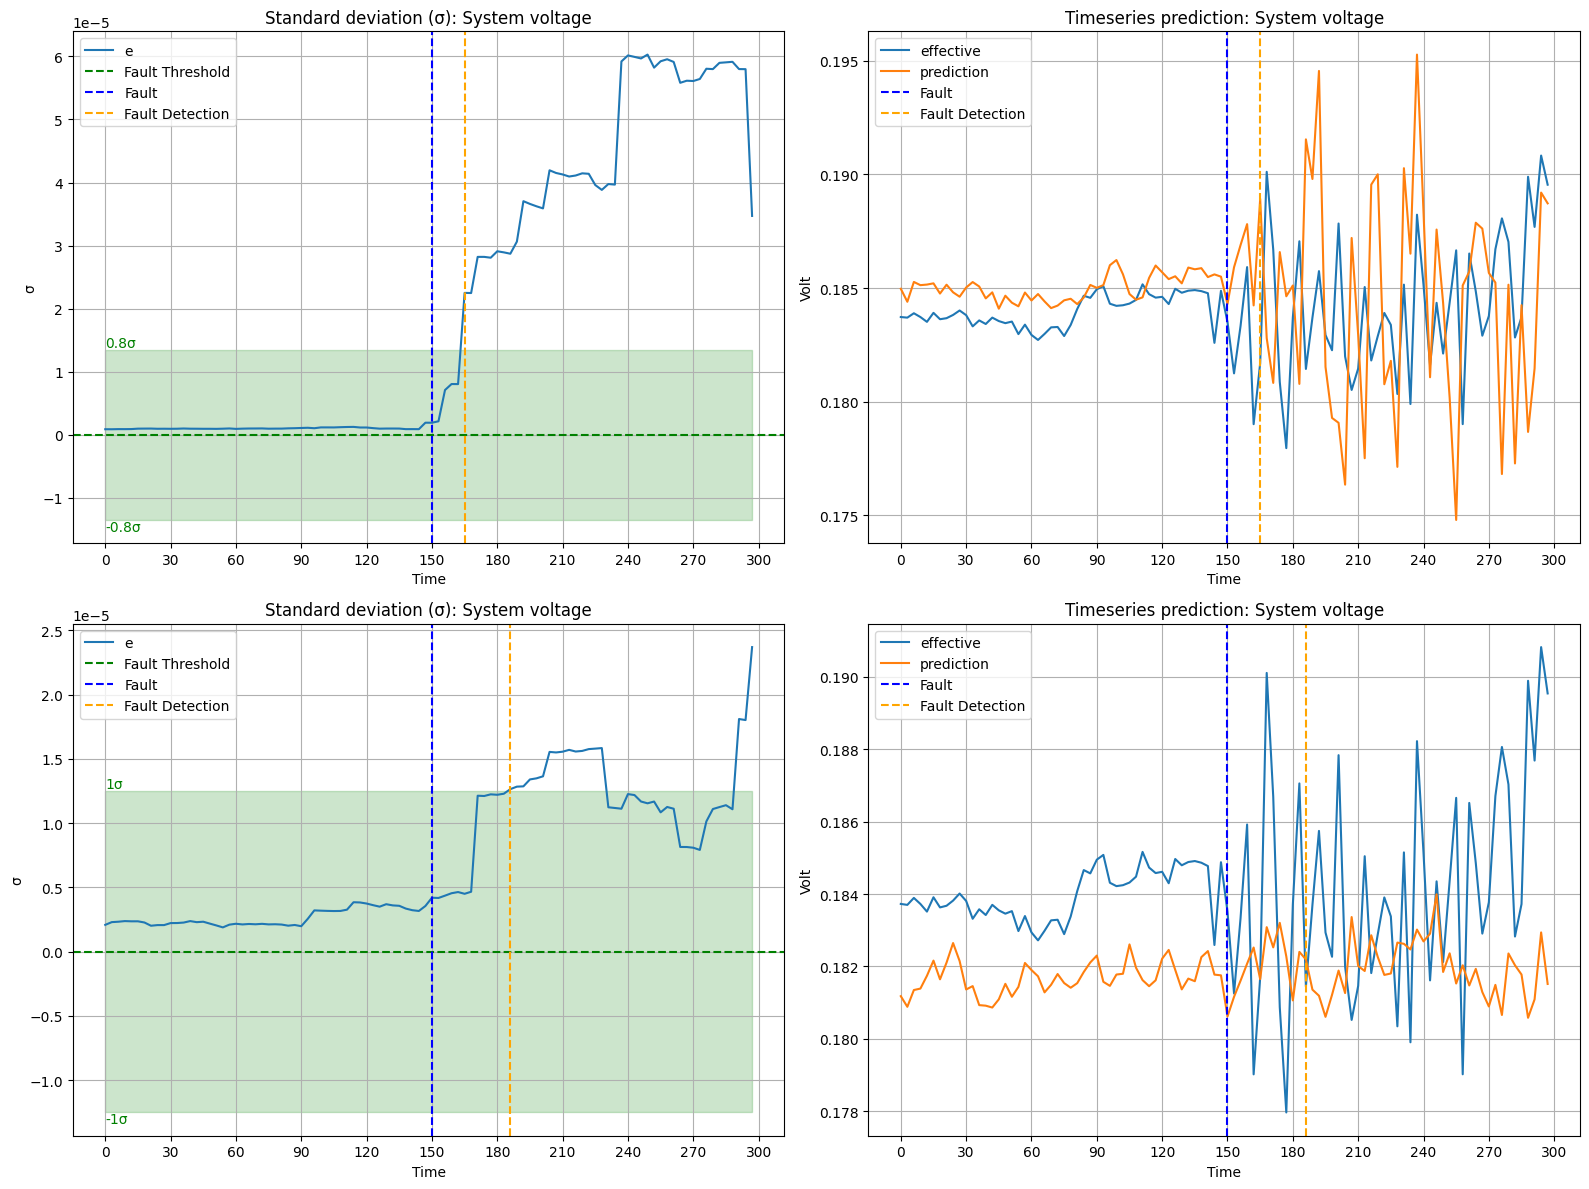

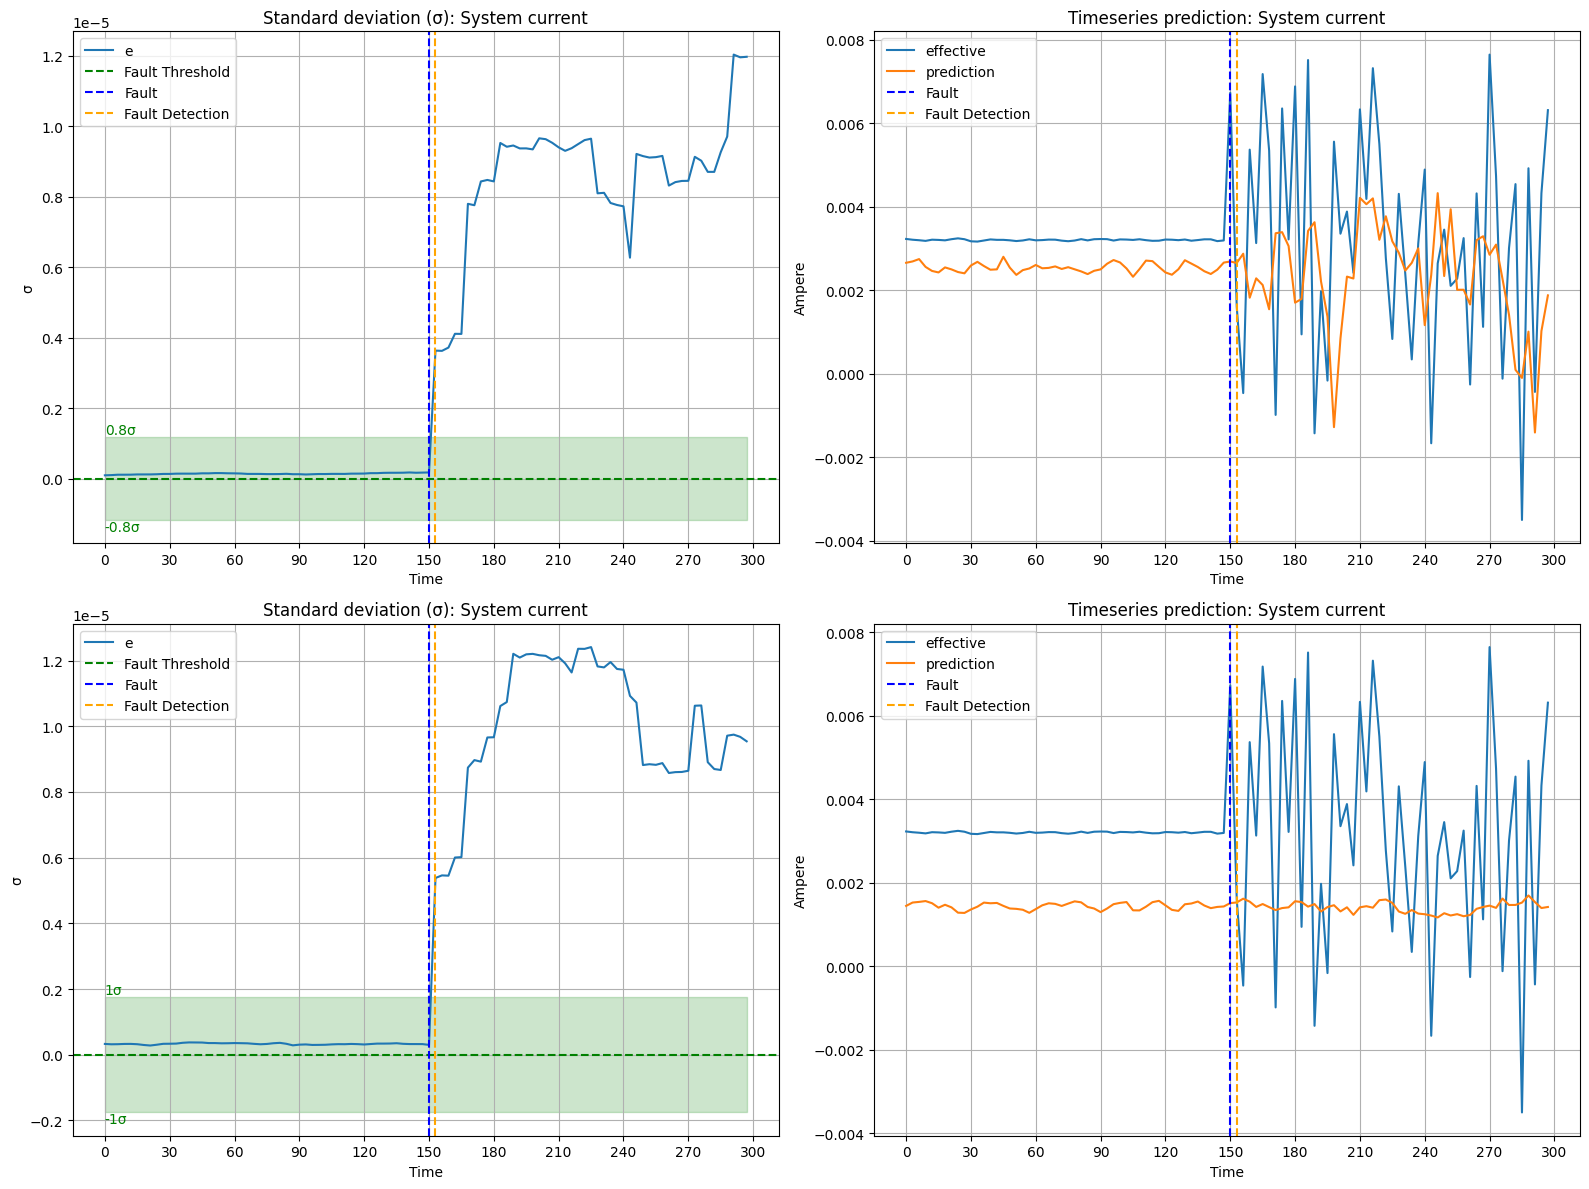

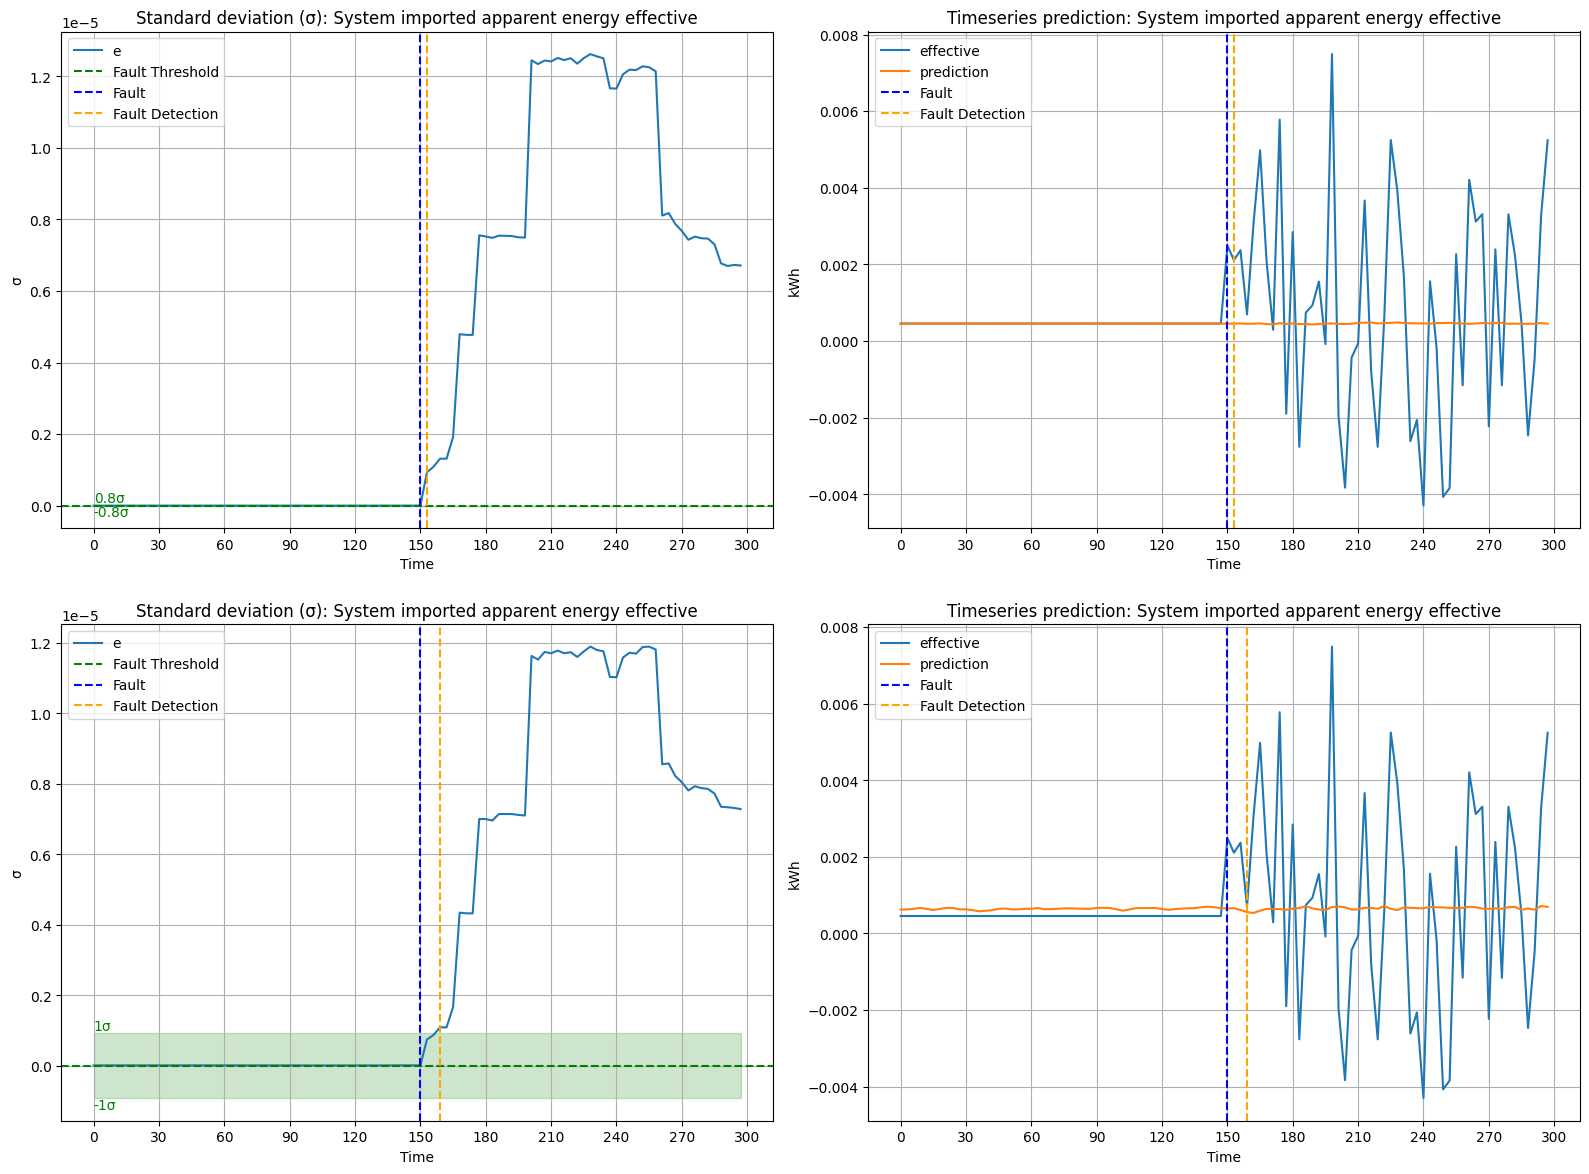

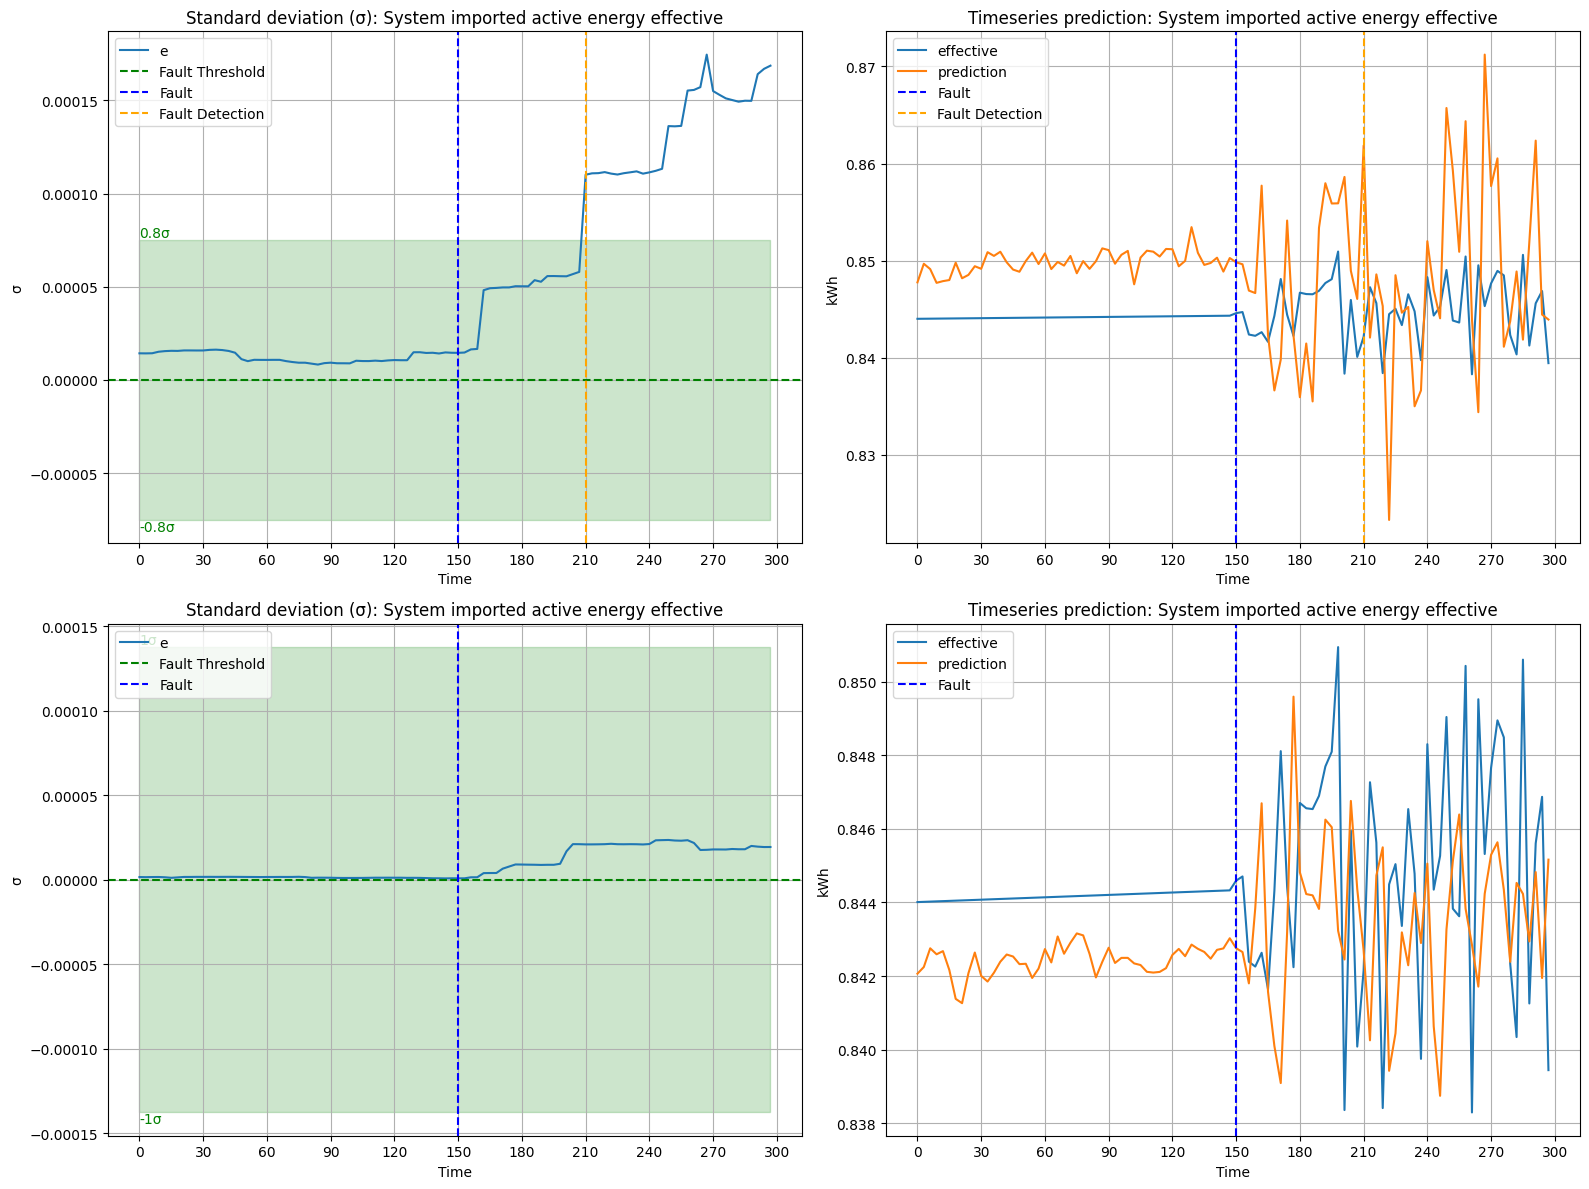

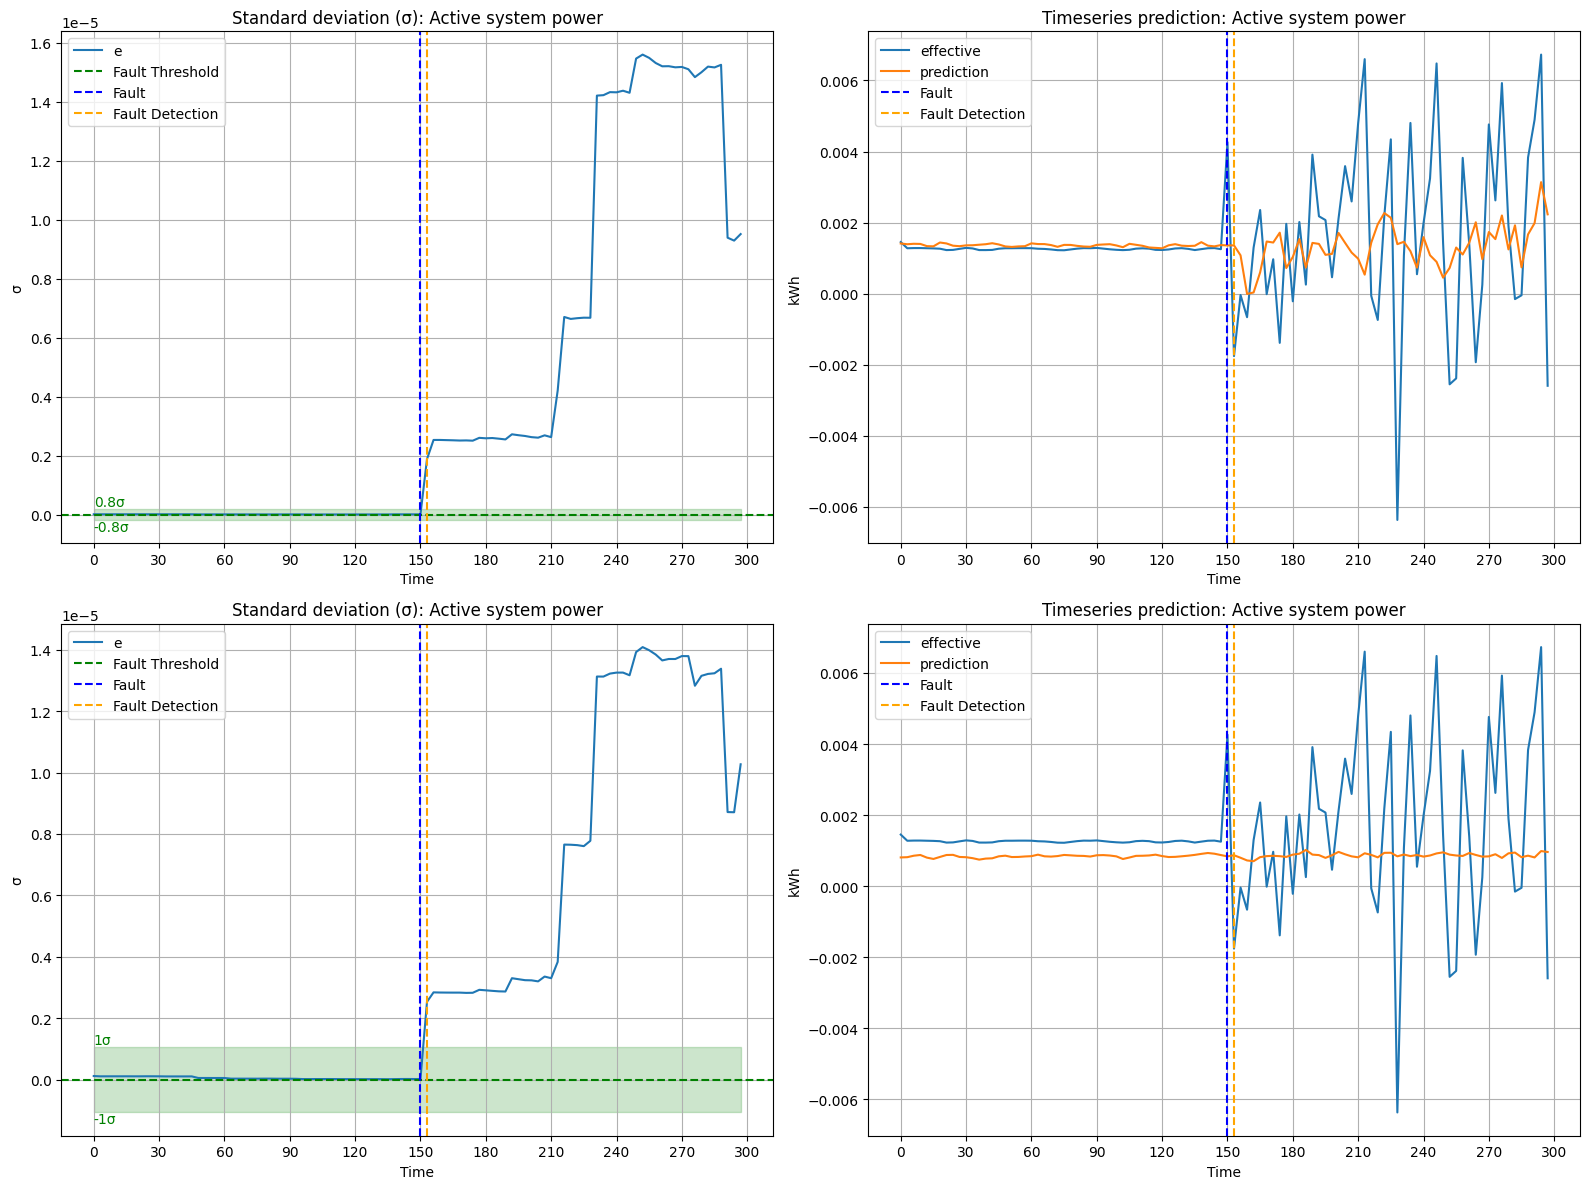

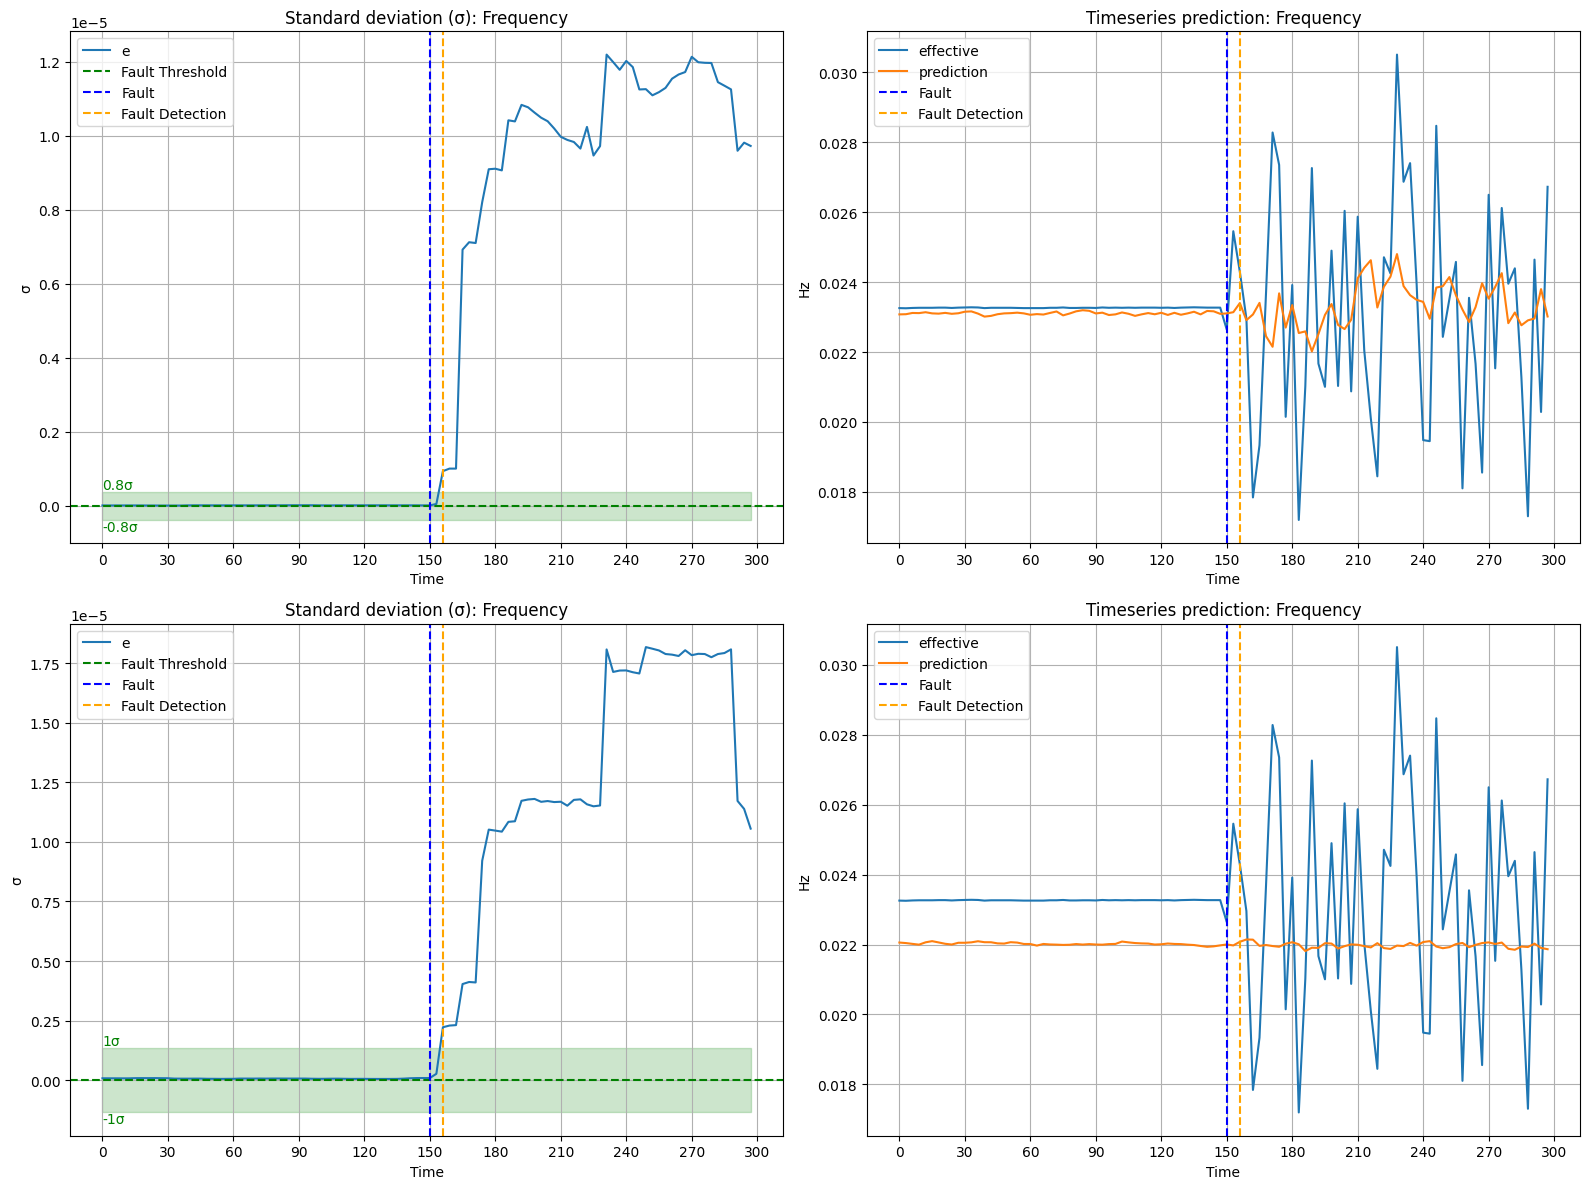

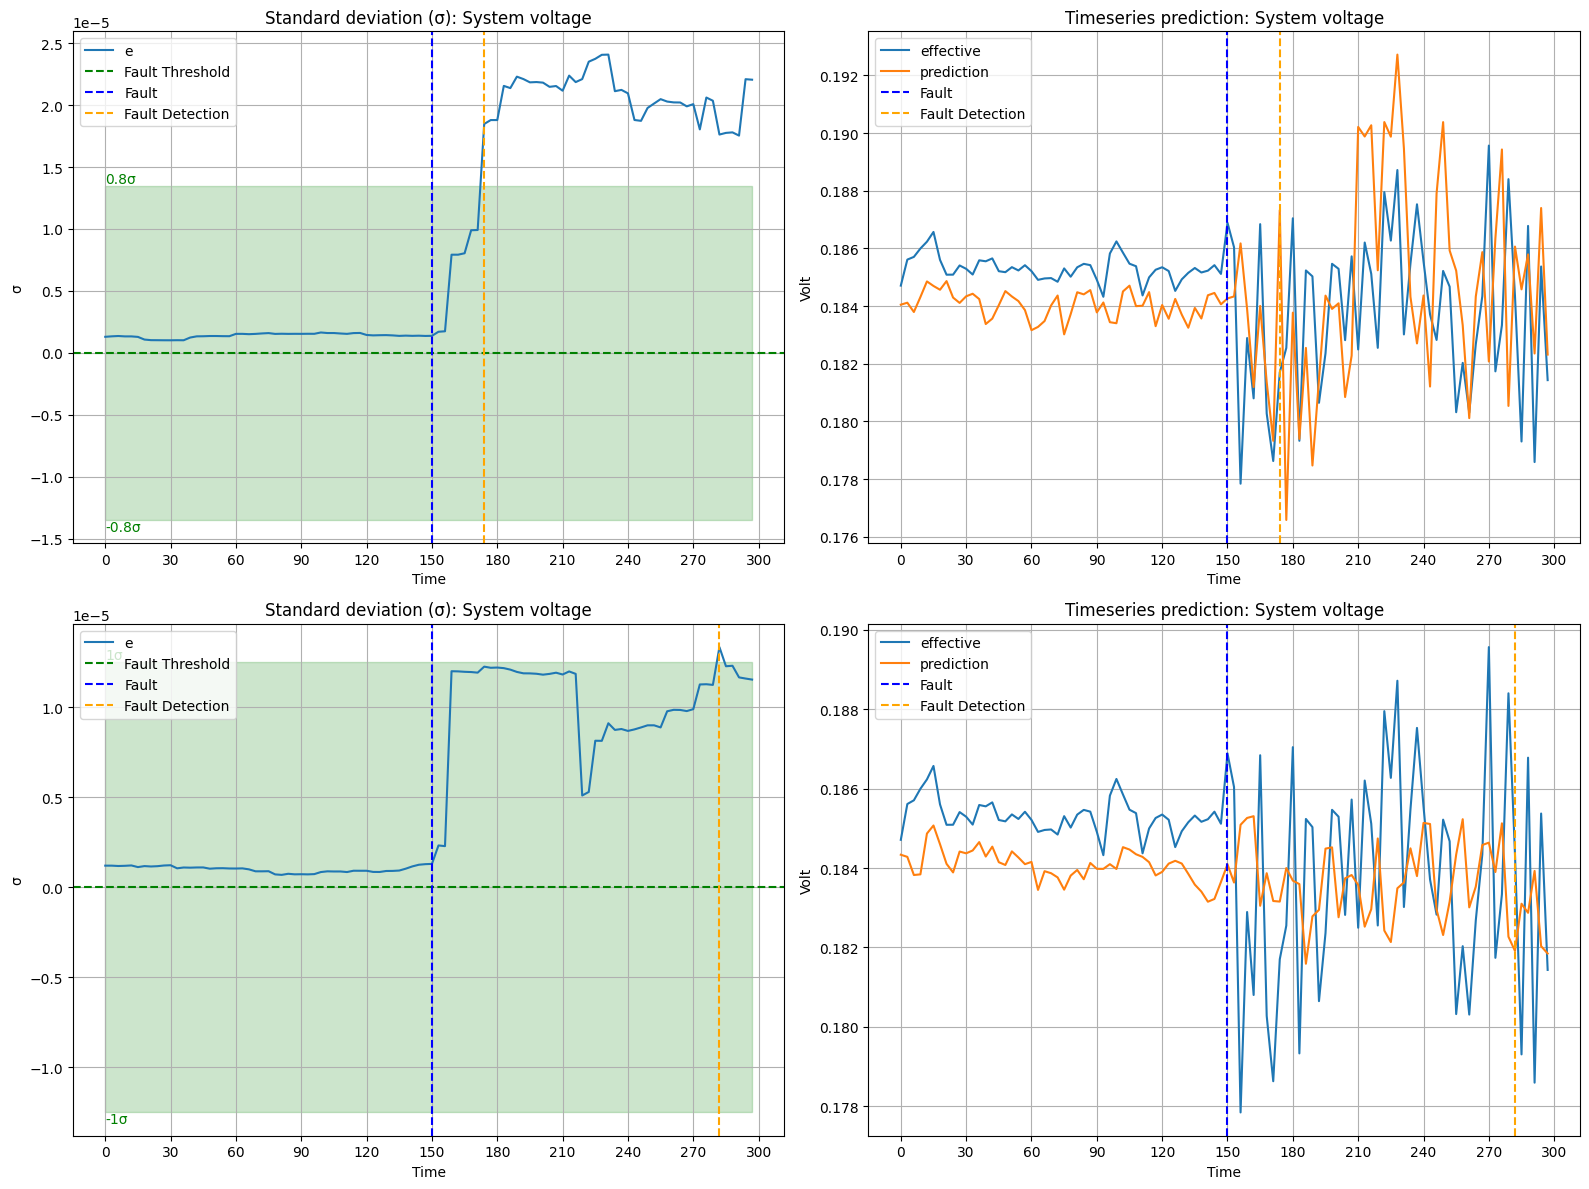

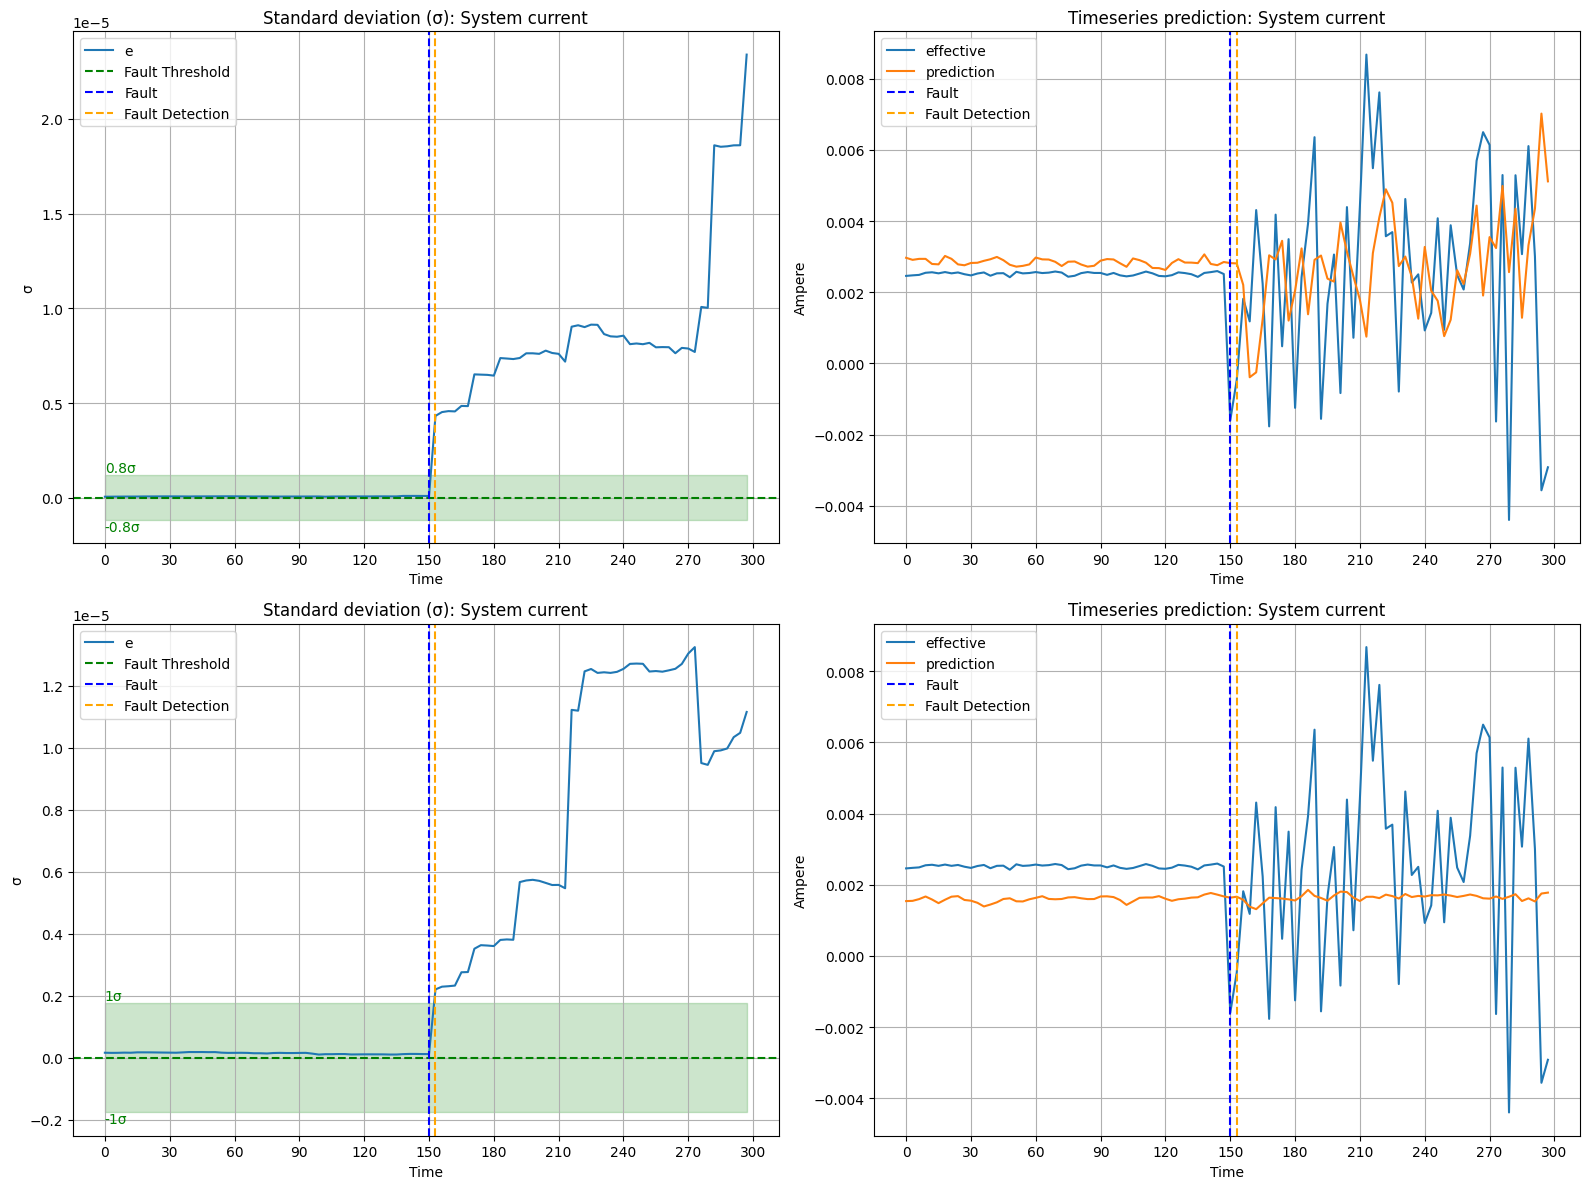

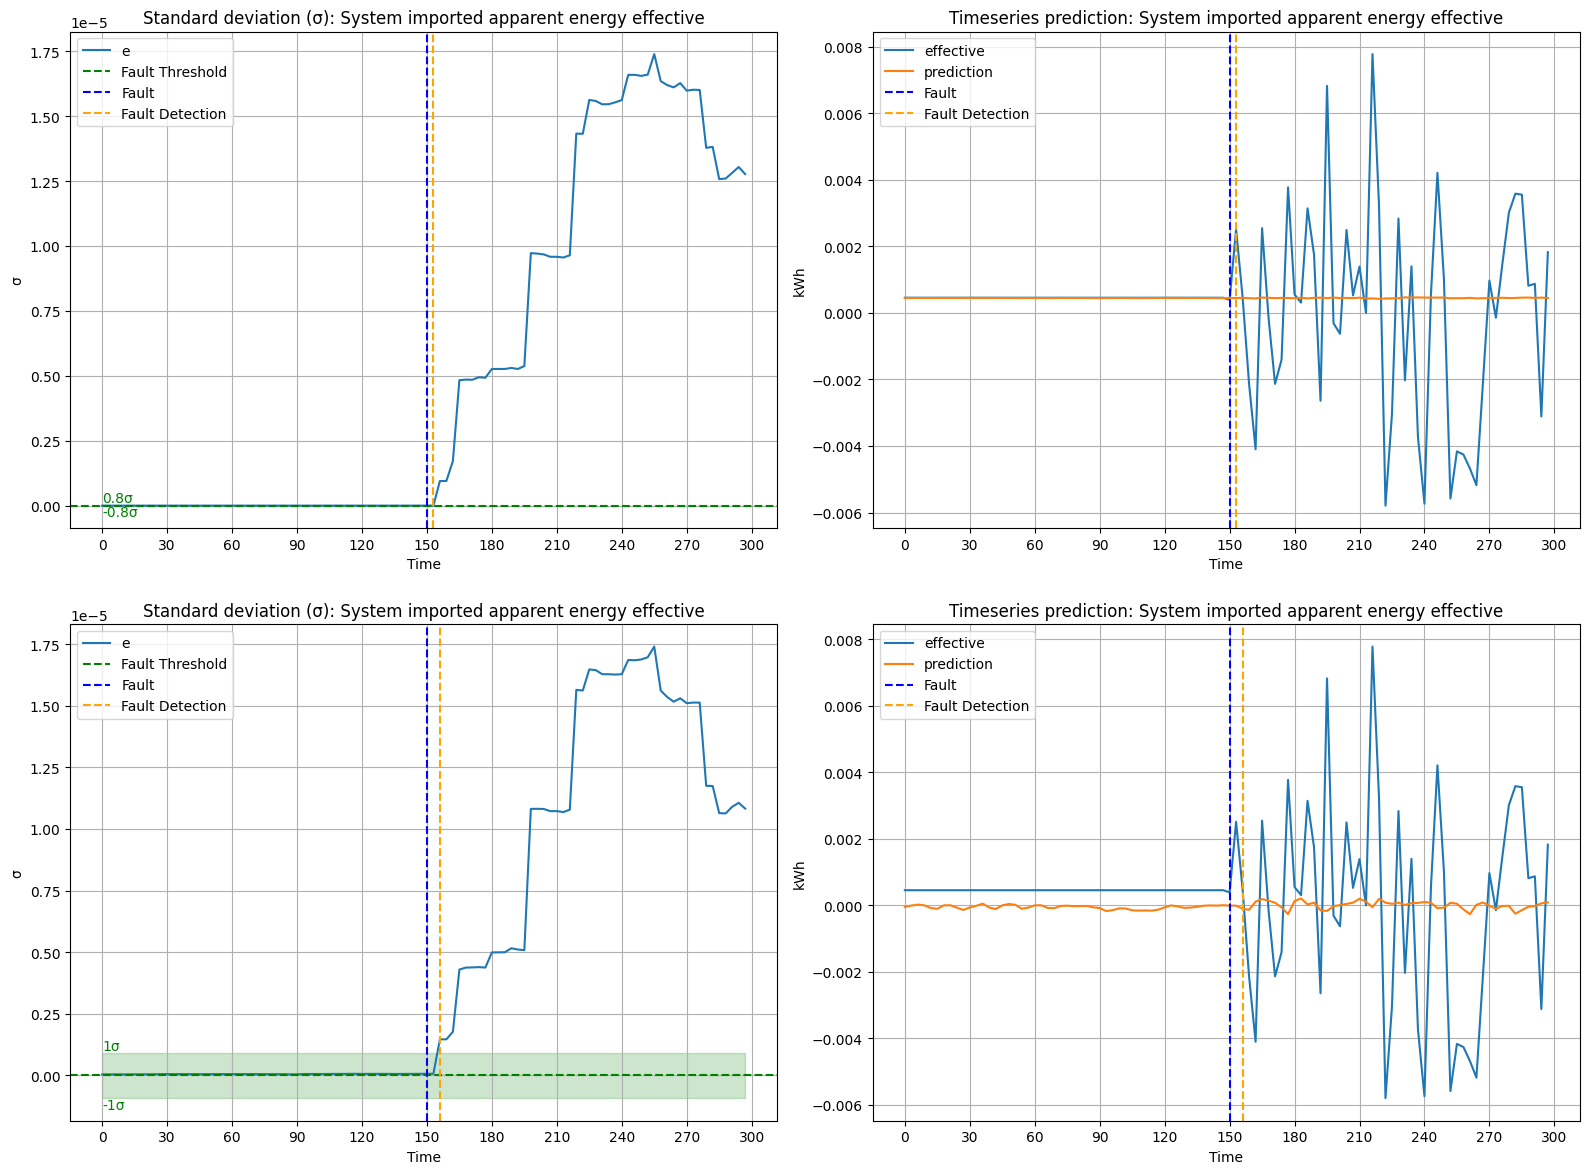

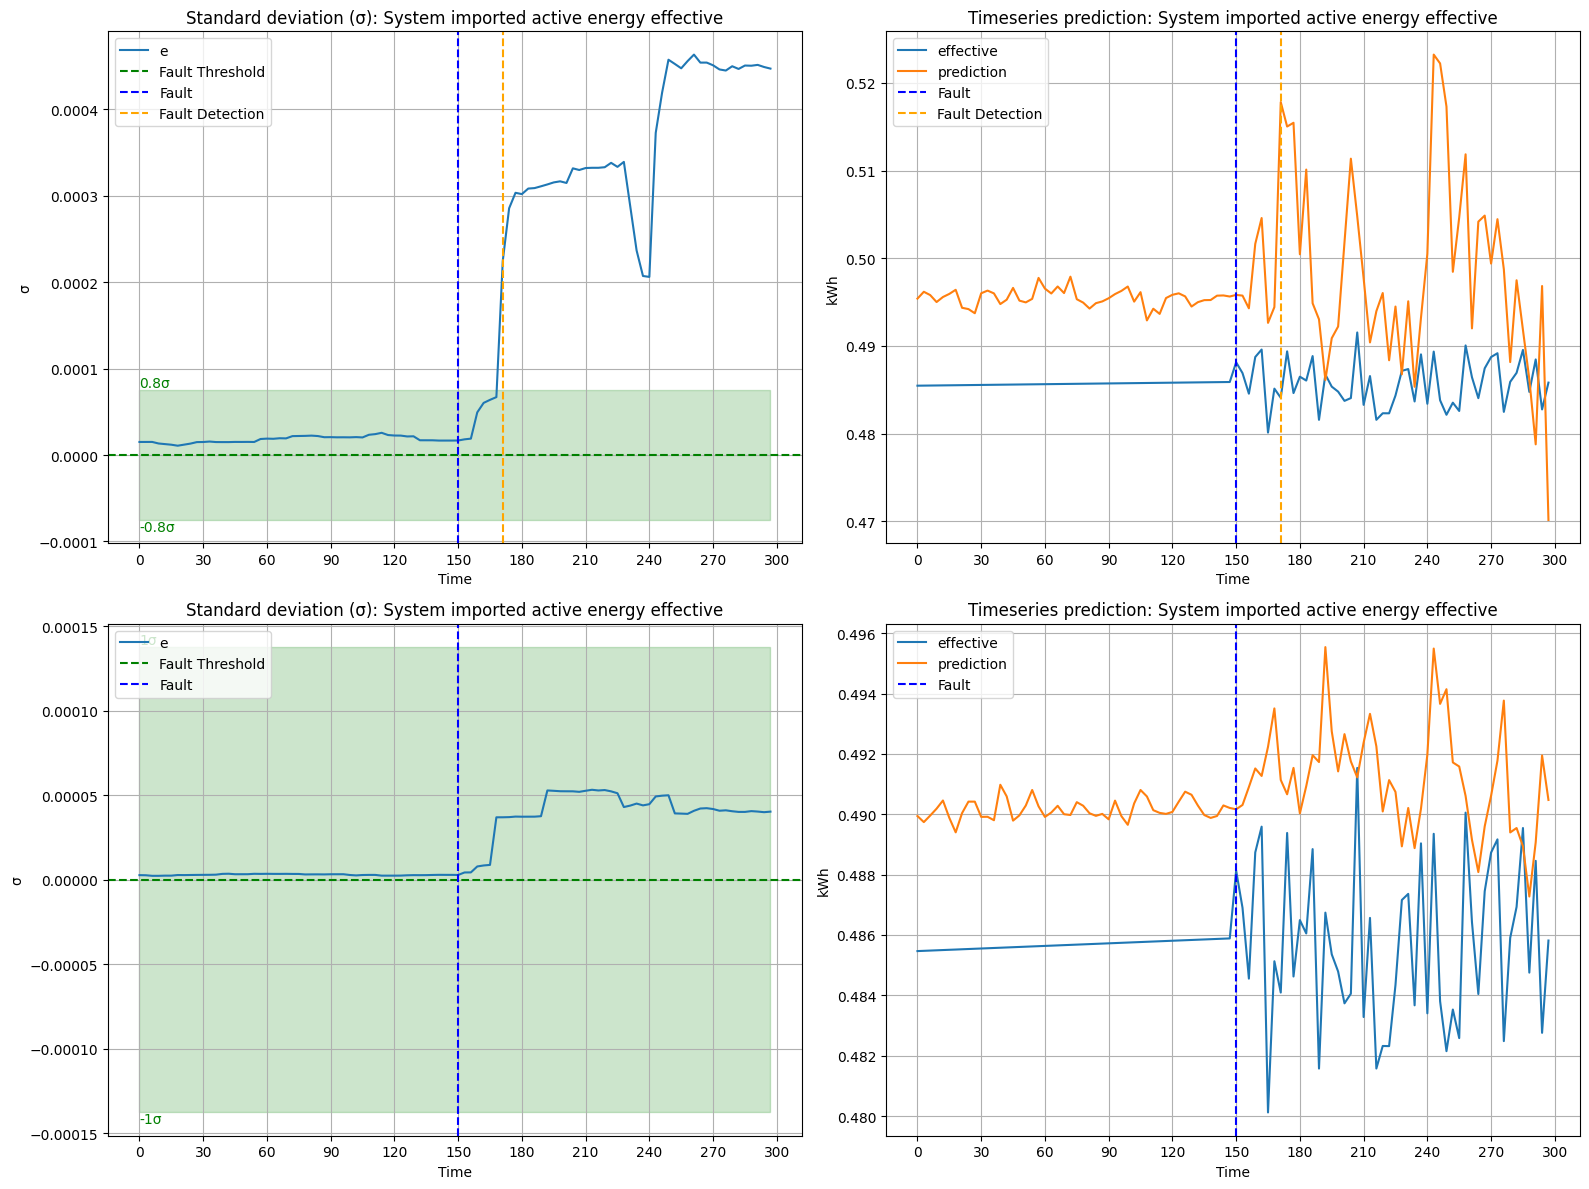

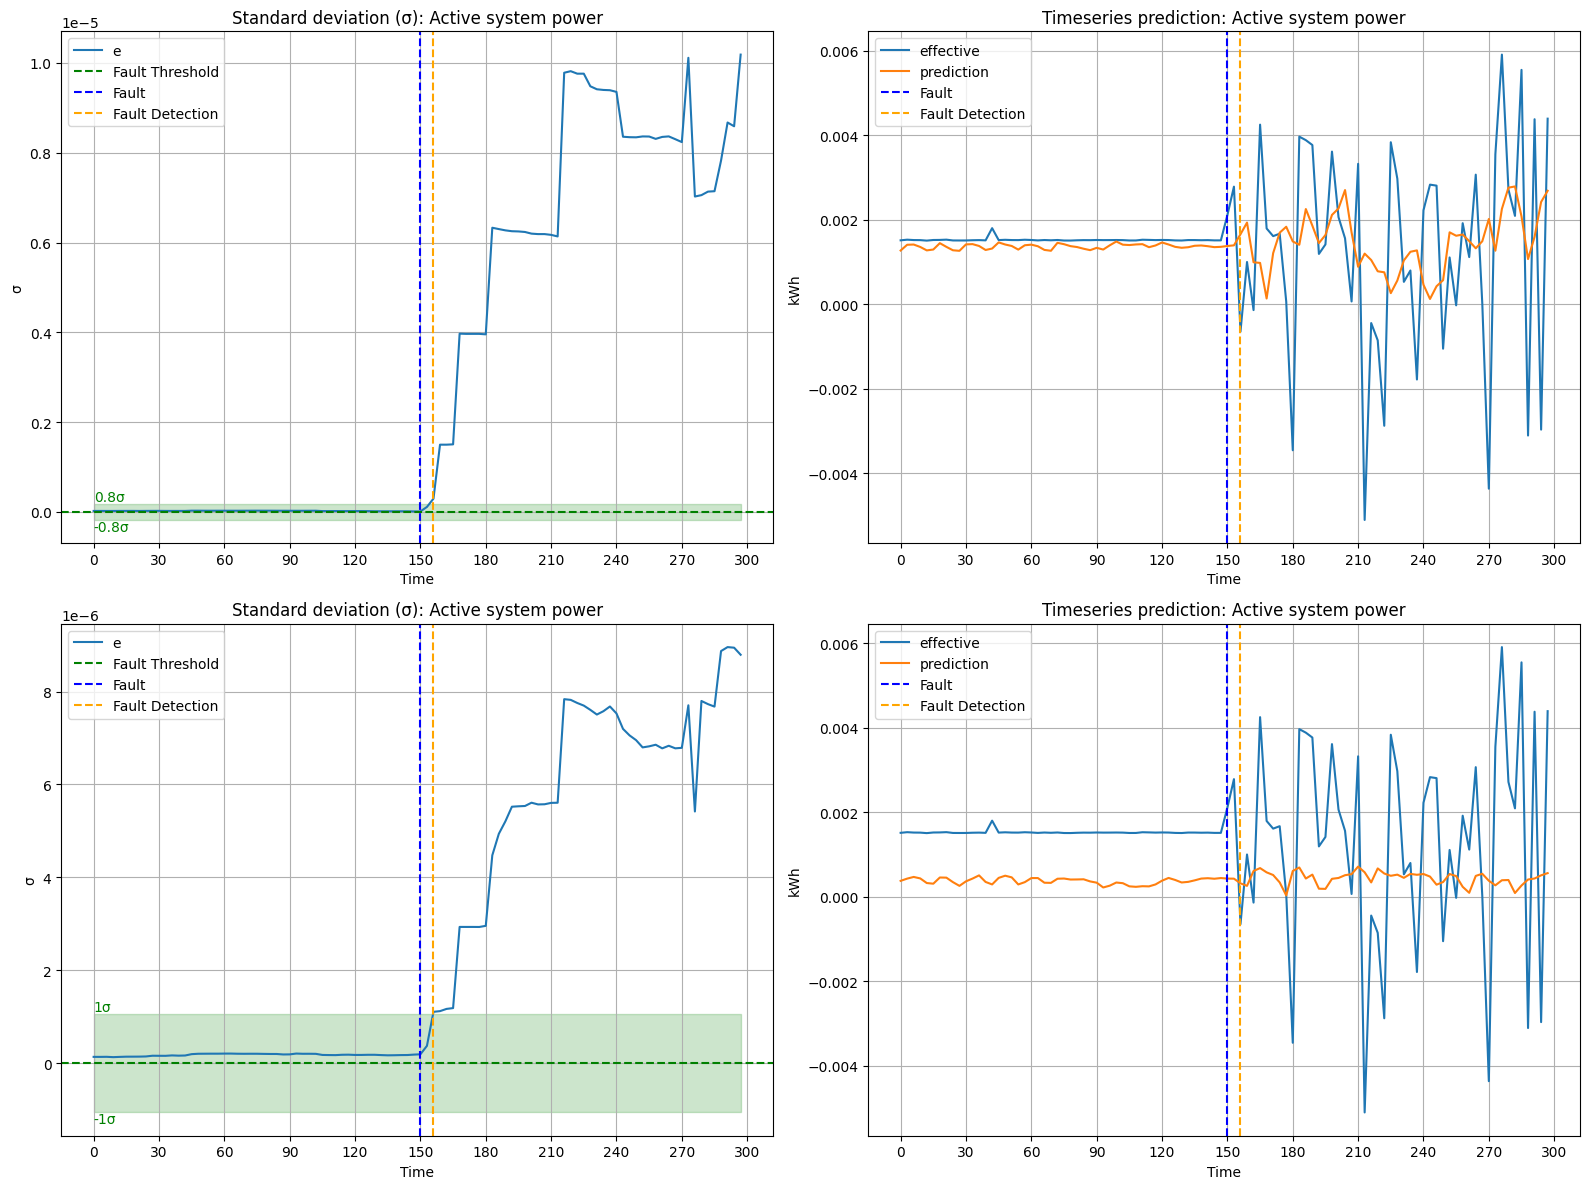

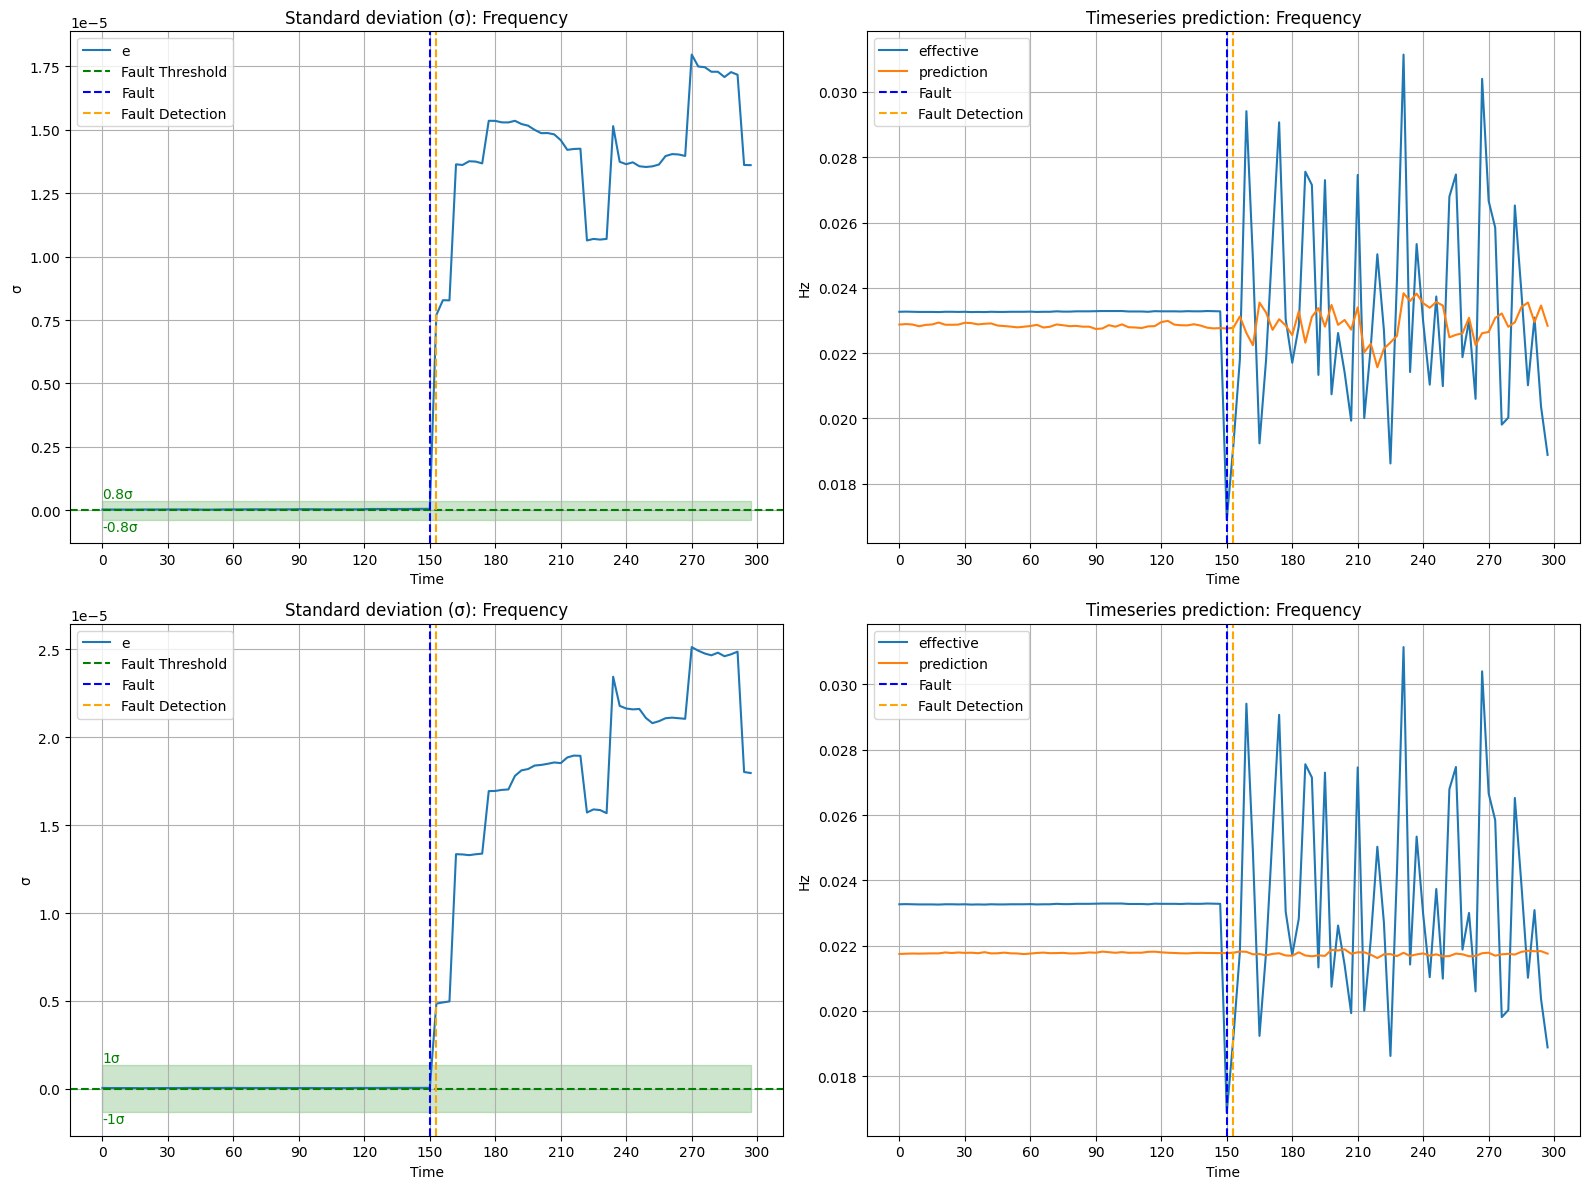

KeyboardInterrupt: 

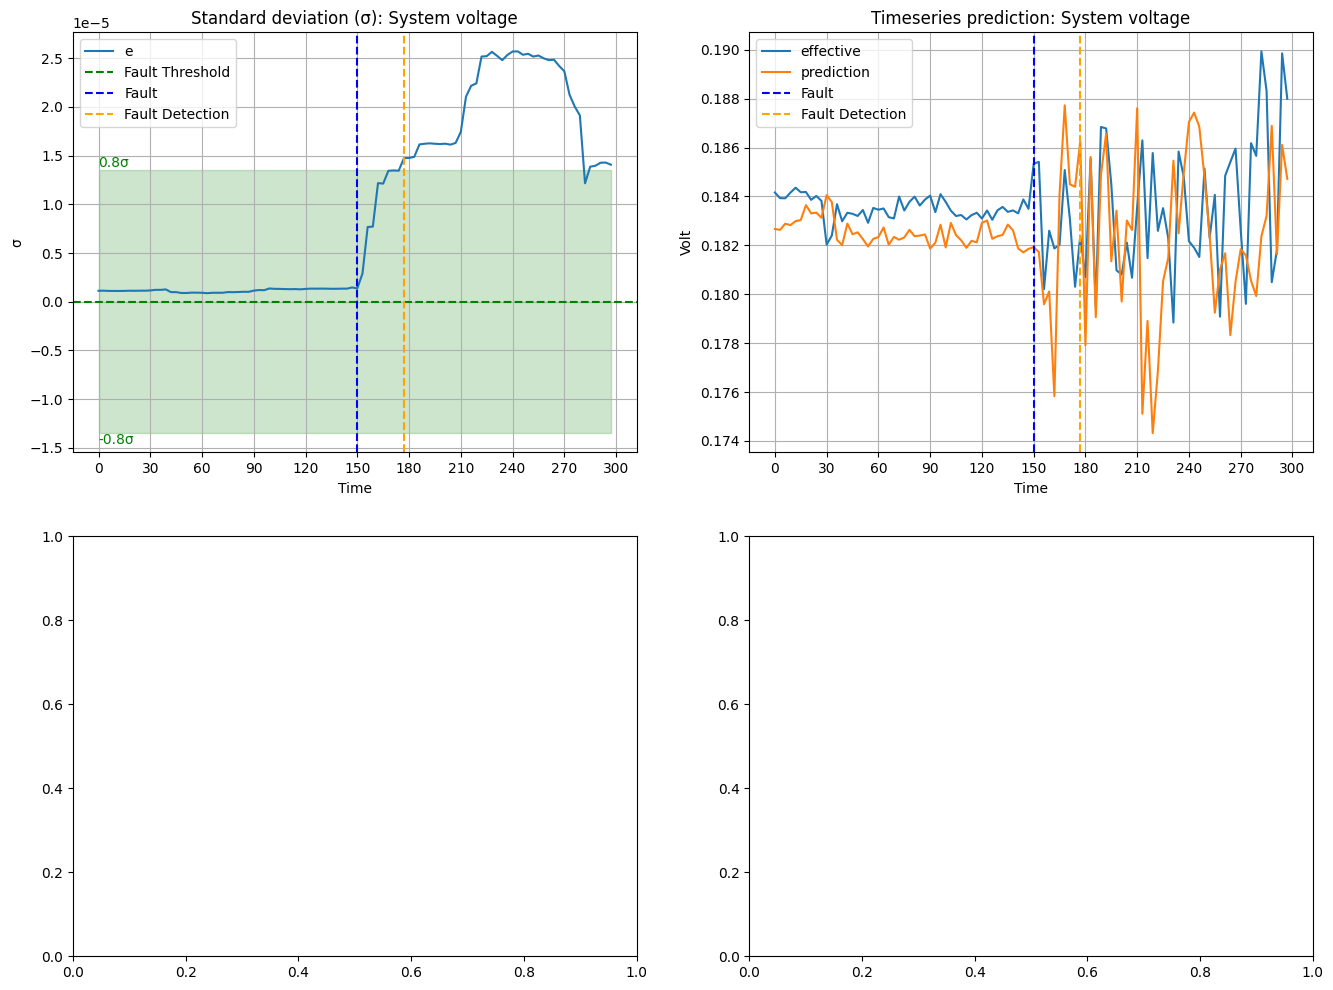

In [28]:

# plot
zoom = 50
start = - (150 + zoom)
end = - (150 - zoom)
models = [model_echo, model_lstm]
create_subplots(ts_dataset, start, end, models)

